***Import libraires and data, set up stuff***

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
#import anndata2ri

In [3]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
#anndata2ri.activate()
%load_ext rpy2.ipython

In [4]:
plt.rcParams['figure.figsize']=(6,6) #rescale figures

In [5]:
%%R
library(matrixStats)
library(adegenet)
library(vcfR)
library(ggplot2)

In [6]:
%%R
vcf <- read.vcfR("../../pruning/5e5.gatk4_laks_onTarget_lociKeepHo0.5.recode.vcf") 
gt <- extract.gt(vcf, return.alleles = FALSE)  # with TRUE returns the A-G-C-T instead of 1/0, 0/0,...
dataset <- as.data.frame(gt)                   # create dataframe of genotypes 

Scanning file to determine attributes.
File attributes:
  meta lines: 232196
  header_line: 232197
  variant count: 2194
  column count: 915
Meta line 1000 read in.2000 read in.3000 read in.4000 read in.5000 read in.6000 read in.7000 read in.8000 read in.9000 read in.10000 read in.11000 read in.12000 read in.13000 read in.14000 read in.15000 read in.16000 read in.17000 read in.18000 read in.19000 read in.20000 read in.21000 read in.22000 read in.23000 read in.24000 read in.25000 read in.26000 read in.27000 read in.28000 read in.29000 read in.30000 read in.31000 read in.32000 read in.33000 read in.34000 read in.35000 read in.36000 read in.37000 read in.38000 read in.39000 read in.40000 read in.41000 read in.42000 read in.43000 read in.44000 read in.45000 read in.46000 read in.47000 read in.48000 read in.49000 read in.50000 read in.51000 read in.52000 read in.53000 read in.54000 read in.55000 read in.56000 read in.57000 read in.58000 read in.59000 read in.60000 read in.61000 read in.6200

In [7]:
%%R
# CALCULATE MEAN HETEROZYGOSITY #
nNa <- 0                              # create empty vectors
meanHet <- 0 
for (i in c(1:ncol(dataset))){        # calculate the mean heterozygosity for every individual in the dataset
  snpIndv = sum(!is.na(dataset[, i])) # for each individual count how many snps are different from NA
  meanHet[i] <- 1-(sum(dataset[,i] == "0/0" | dataset[,i] == "1/1", na.rm = TRUE)/snpIndv) # number of homozygous on the total number of individual genotyped SNPs
  nNa[i] <- nrow(dataset) - snpIndv
}


  |============================================================| 100%

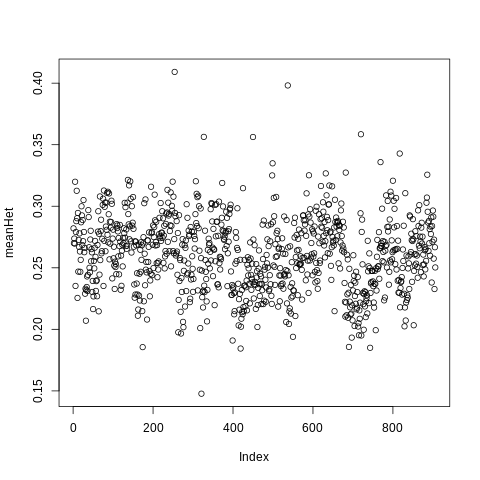

In [8]:
%%R
myHet <- function(dataset){           # create randomized dataset with replacement of the SNPs
  xx = dataset[sample(nrow(dataset), nrow(dataset), replace = T), ] 
  z <- 0 
  for (i in 1:ncol(dataset)) {
    snpIndv = sum(!is.na(xx[, i]))    # n. of snp segregating per individual, that have been genotyped
    z[i] <- 1 - (sum(xx[, i] == "0/0" | xx[, i] == "1/1", na.rm = TRUE) / snpIndv)
  }
  return(z)
}
# BOOTSTRAP FUNCTION #
repeatHet <- function(dataset, replicates) {   
  recipient <- matrix(ncol = ncol(dataset), nrow = replicates)
  pb <- txtProgressBar(min = 0, max = replicates, style = 3, width = 60)
  for (i in 1:replicates)  {
    recipient[i, ] <- myHet(dataset)
    i = i + 1
    setTxtProgressBar(pb, i)
    flush.console()
  }
  colnames(recipient) = colnames(dataset)
  return(recipient)
}
# STANDARD ERROR #
myBSdis_He <- repeatHet(dataset, replicates = 100)
SE_het <- colSds(myBSdis_He)
plot(meanHet)


In [9]:
%%R
# PLOT #
het <- read.table("../../pruning/indiv_5e5")                  # individual names
het$meanHet <- meanHet                          # add mean heterozygosity
het$SE_het <- SE_het                            # add standard error 
het$NAs <- nNa                                  # add missing data

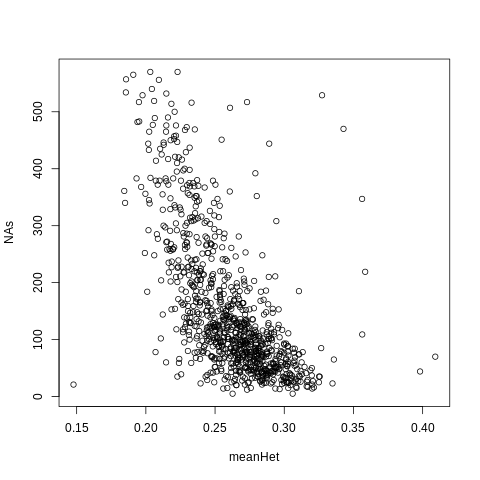

In [10]:
%%R
nrow(het)    # number of individuals in original file
# plot correlation between missing data and level of heterozygosity
with(het, plot(x = meanHet, y = NAs))
# which is the sample with the higher number of missing data
#newdata[which(newdata$NAs == max(newdata$NAs)), ]
#head(newdata)


In [11]:
%%R -o het
het

                            V1   meanHet      SE_het NAs
1          Atr_99_01_HFGGJBBXY 0.2820268 0.009822998 102
2          Atr_99_02_HFGGJBBXY 0.2700283 0.009665205  72
3          Atr_99_03_HFGGJBBXY 0.2737482 0.009785618  57
4          Atr_99_04_HFGGJBBXY 0.2696682 0.009202445  84
5          Atr_99_05_HFGGJBBXY 0.3198887 0.008792746  37
6          Atr_99_06_HFGGJBBXY 0.2352657 0.009105061 124
7          Atr_99_07_HFGGJBBXY 0.2790809 0.009420151 105
8          Atr_99_08_HFGGJBBXY 0.2878716 0.008800229  75
9          Atr_99_09_HFGGJBBXY 0.3125586 0.009768450  60
10         Atr_99_10_HFGGJBBXY 0.2902622 0.011073415  58
11         Atr_99_11_HFGGJBBXY 0.2255220 0.009479933  39
12         Atr_99_12_HFGGJBBXY 0.2945368 0.010072024  89
13         Atr_99_13_HFGGJBBXY 0.2469018 0.009249872  96
14         Atr_99_14_HFGGJBBXY 0.2726843 0.009908879  78
15         Atr_99_15_HFGGJBBXY 0.2669574 0.010376144 130
16         Atr_99_16_HFGGJBBXY 0.2779343 0.010472172  64
17         Atr_99_17_HFGGJBBXY 

286         SK_08_33_HFNFVBBXY 0.2906024 0.010343242 119
287         SK_08_34_HFNFVBBXY 0.2455805 0.010035291 101
288         SK_08_35_HFNFVBBXY 0.2534806 0.009184775 111
289         SK_08_36_HFNFVBBXY 0.2802045 0.010205323  42
290         SK_08_37_HFNFVBBXY 0.2758146 0.008759191  15
291         SK_08_38_HFNFVBBXY 0.2769679 0.008762941 136
292         SK_08_39_HFNFVBBXY 0.2220617 0.008937907 118
293          SK_08_3_HFNFVBBXY 0.2249117 0.009029169 211
294         SK_08_40_HFNFVBBXY 0.2831354 0.009506386  89
295         SK_08_41_HFNFVBBXY 0.2404878 0.008167221 144
296         SK_08_42_HFNFVBBXY 0.2443418 0.009102953  29
297         SK_08_43_HFNFVBBXY 0.2793843 0.009199719  50
298         SK_08_44_HFNFVBBXY 0.2593320 0.009136383 158
299         SK_08_45_HFNFVBBXY 0.2491647 0.009483245  99
300         SK_08_46_HFNFVBBXY 0.2304305 0.010487036 150
301         SK_08_47_HFNFVBBXY 0.2409351 0.010695907  98
302         SK_08_48_HFNFVBBXY 0.2792363 0.009726242  99
303         SK_08_49_HFNFVBBXY 

572         ST_01_64_HFNFVBBXY 0.2483381 0.009168441  88
573         ST_01_67_HFNFVBBXY 0.2241541 0.009122957  66
574         ST_01_69_HFNFVBBXY 0.2581094 0.009831012  36
575        ST_02_104_HFNFVBBXY 0.2923788 0.008844296  29
576        ST_02_106_HFNFVBBXY 0.2926478 0.010347734 113
577        ST_02_107_HFNFVBBXY 0.2886199 0.010765724 129
578        ST_02_109_HFNFVBBXY 0.2581429 0.009415623 137
579        ST_02_111_HFNFVBBXY 0.2802249 0.009741544  60
580        ST_02_114_HFNFVBBXY 0.2852490 0.009543151  45
581        ST_02_115_HFNFVBBXY 0.2885452 0.009499595 125
582        ST_02_119_HFNFVBBXY 0.2398190 0.008942438 205
583        ST_02_126_HFNFVBBXY 0.2759277 0.009283447  92
584        ST_02_128_HFNFVBBXY 0.3104727 0.009573200  36
585        ST_02_129_HFNFVBBXY 0.2596525 0.009645180 122
586         ST_05_10_HFNFVBBXY 0.2445703 0.009864799  76
587         ST_05_11_HFNFVBBXY 0.2558257 0.008702611 220
588         ST_05_12_HFNFVBBXY 0.2933769 0.011474187  50
589         ST_05_13_HFNFVBBXY 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 109
771         VA_01_47_HFNFVBBXY 0.2700324 0.011068006  35
772         VA_01_58_HFNFVBBXY 0.2677949 0.009979205 185
773         VA_01_75_HFNFVBBXY 0.2980319 0.009127187  60
774 VA_01_C19vgl6123_HFNFVBBXY 0.2554427 0.008038504 127
775       VA_01_L100_HFNFVBBXY 0.2717073 0.010433524 144
776        VA_01_L94_HFNFVBBXY 0.2628766 0.010456754 136
777       VA_02_1003_HFNFVBBXY 0.2544379 0.009442418 166
778       VA_02_1004_HFNFVBBXY 0.2235294 0.009080264 239
779       VA_02_1006_HFNFVBBXY 0.2710843 0.009416366 202
780       VA_02_1014_HFNFVBBXY 0.2258393 0.008902772 228
781       VA_02_1022_HFNFVBBXY 0.2639594 0.010350387  27
782       VA_02_1024_HFNFVBBXY 0.2678402 0.010085061  92
783       VA_02_1026_HFNFVBBXY 0.3088303 0.010627911  31
784       VA_02_1032_HFNFVBBXY 0.2686638 0.009671103  91
785       VA_02_1035_HFNFVBBXY 0.2502334 0.009537108  52
786       VA_02_1039_HFNFVBBXY 0.2831609 0.009777412  68
787         VA_06_10_HFNFVBBXY 0.3042672 0.010007531  38
788         VA_06_11_HFNFV

In [12]:
%%R -o dataset
head(dataset)

                    Atr_99_01_HFGGJBBXY Atr_99_02_HFGGJBBXY Atr_99_03_HFGGJBBXY
NC_027300.1_2281538                 1/1                 0/1                 1/1
NC_027300.1_2281558                 1/1                 0/1                 0/1
NC_027300.1_2334132                 0/0                 0/0                 0/0
NC_027300.1_2586558                 0/1                 0/0                 0/1
NC_027300.1_2763979                 0/0                 0/1                 0/0
NC_027300.1_2763981                 0/0                 0/1                 0/0
                    Atr_99_04_HFGGJBBXY Atr_99_05_HFGGJBBXY Atr_99_06_HFGGJBBXY
NC_027300.1_2281538                 0/1                 0/0                 1/1
NC_027300.1_2281558                 0/1                 0/0                 0/1
NC_027300.1_2334132                 0/1                 0/0                 0/0
NC_027300.1_2586558                 0/1                 0/0                 0/0
NC_027300.1_2763979                 0/1 

NC_027300.1_2281538                 1/1                 1/1                 0/1
NC_027300.1_2281558                 0/0                 1/1                 0/1
NC_027300.1_2334132                 0/1                 0/0                 0/0
NC_027300.1_2586558                 0/0                 0/1                 0/0
NC_027300.1_2763979                 0/0                 0/0                 0/0
NC_027300.1_2763981                 0/0                 0/0                 0/0
                    Cor_99_01_HFGGJBBXY Cor_99_02_HFGGJBBXY Cor_99_03_HFGGJBBXY
NC_027300.1_2281538                <NA>                 0/1                 1/1
NC_027300.1_2281558                <NA>                 0/0                 1/1
NC_027300.1_2334132                 1/1                 0/1                 0/0
NC_027300.1_2586558                 0/0                 0/0                 0/0
NC_027300.1_2763979                 0/0                 0/1                 0/0
NC_027300.1_2763981                 0/0 

                    RB_03_201_HFNFVBBXY RB_06_10_HFNFVBBXY RB_06_15_HFNFVBBXY
NC_027300.1_2281538                 0/0               <NA>                1/1
NC_027300.1_2281558                 0/0               <NA>               <NA>
NC_027300.1_2334132                 0/0                0/0                0/0
NC_027300.1_2586558                 0/0                0/0                0/0
NC_027300.1_2763979                 0/0                0/0                0/0
NC_027300.1_2763981                 0/0                0/0                0/0
                    RB_06_22_HFNFVBBXY RB_06_23_HFNFVBBXY RB_06_24_HFNFVBBXY
NC_027300.1_2281538                0/0                1/1                1/1
NC_027300.1_2281558                0/0                0/0                1/1
NC_027300.1_2334132                0/0                0/0                0/0
NC_027300.1_2586558                0/1                0/0                0/1
NC_027300.1_2763979                0/0                0/0            

NC_027300.1_2334132                0/1                0/0                0/1
NC_027300.1_2586558               <NA>                0/1                0/1
NC_027300.1_2763979                0/0                0/0                0/0
NC_027300.1_2763981                0/0                0/0                0/0
                    SK_08_15_HFNFVBBXY SK_08_16_HFNFVBBXY SK_08_17_HFNFVBBXY
NC_027300.1_2281538               <NA>               <NA>                1/1
NC_027300.1_2281558               <NA>               <NA>                1/1
NC_027300.1_2334132                0/0                0/0                0/0
NC_027300.1_2586558                0/0                0/1                0/1
NC_027300.1_2763979                0/0                0/1                0/1
NC_027300.1_2763981                0/0                0/1                0/1
                    SK_08_18_HFNFVBBXY SK_08_19_HFNFVBBXY SK_08_1_HFH73BBXY
NC_027300.1_2281538               <NA>                1/1               1/1
N

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



                0/0
NC_027300.1_2763981                 0/0                0/1                0/0
                    SK_35_97_HFGGJBBXY SK_35_99_HFGGJBBXY SK_36_100_HFGGJBBXY
NC_027300.1_2281538                0/1                1/1                <NA>
NC_027300.1_2281558                0/0                0/0                 0/0
NC_027300.1_2334132                0/1                0/1                 0/0
NC_027300.1_2586558                0/0                0/0                <NA>
NC_027300.1_2763979                0/0                0/0                 0/1
NC_027300.1_2763981                0/0                0/0                 0/1
                    SK_36_124_HFGGJBBXY SK_38_132_HFGGJBBXY SK_38_133_HFGGJBBXY
NC_027300.1_2281538                 1/1                <NA>                 0/0
NC_027300.1_2281558                 1/1                <NA>                 0/0
NC_027300.1_2334132                 0/0                 0/0                 0/0
NC_027300.1_2586558                 

NC_027300.1_2763979                 0/0                 0/0                 0/1
NC_027300.1_2763981                 0/0                 0/0                 0/1
                    SK_92_156_HFGGJBBXY SK_92_157_HFGGJBBXY SK_92_158_HFGGJBBXY
NC_027300.1_2281538                 0/1                 1/1                 1/1
NC_027300.1_2281558                 0/1                 0/0                 1/1
NC_027300.1_2334132                 0/1                 0/0                 0/0
NC_027300.1_2586558                 0/1                 0/0                 1/1
NC_027300.1_2763979                 0/0                 0/0                 0/1
NC_027300.1_2763981                 0/0                 0/0                 0/1
                    SK_92_159_HFGGJBBXY SK_92_160_HFGGJBBXY SK_92_161_HFGGJBBXY
NC_027300.1_2281538                 1/1                 1/1                 1/1
NC_027300.1_2281558                 0/0                 0/0                 1/1
NC_027300.1_2334132                 0/0 

NC_027300.1_2763981                0/0                0/0                0/0
                    ST_05_29_HFNFVBBXY ST_05_2_HFNFVBBXY ST_05_31_HFH73BBXY
NC_027300.1_2281538                1/1               1/1                1/1
NC_027300.1_2281558                0/0               0/1               <NA>
NC_027300.1_2334132                0/0               0/0                0/0
NC_027300.1_2586558                0/1               0/0                0/1
NC_027300.1_2763979                0/0               0/0                0/0
NC_027300.1_2763981                0/0               0/0                0/0
                    ST_05_32_HFNFVBBXY ST_05_33_HFNFVBBXY ST_05_34_HFNFVBBXY
NC_027300.1_2281538               <NA>                1/1                1/1
NC_027300.1_2281558                0/0                0/0               <NA>
NC_027300.1_2334132                0/0                0/0                0/0
NC_027300.1_2586558                0/1                0/1                0/1
NC_027

NC_027300.1_2281538                1/1                0/1               <NA>
NC_027300.1_2281558                0/1                0/1               <NA>
NC_027300.1_2334132                0/0                0/0                0/0
NC_027300.1_2586558                0/0                0/0                1/1
NC_027300.1_2763979                0/0                0/0                0/0
NC_027300.1_2763981                0/0                0/0                0/0
                    ST_13_13_HFGGJBBXY ST_13_15_HFGGJBBXY ST_13_16_HFGGJBBXY
NC_027300.1_2281538               <NA>                1/1                1/1
NC_027300.1_2281558               <NA>                1/1                0/1
NC_027300.1_2334132                0/0                0/0                0/0
NC_027300.1_2586558               <NA>                0/0               <NA>
NC_027300.1_2763979                0/0                0/0                0/0
NC_027300.1_2763981                0/0                0/0                0/0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



                1/1               1/1               1/1
NC_027300.1_2281558                1/1               0/1               0/1
NC_027300.1_2334132                0/0               0/1               0/0
NC_027300.1_2586558                0/1               0/1               0/0
NC_027300.1_2763979                0/0               0/1               0/0
NC_027300.1_2763981                0/0               0/1               0/0
                    VA_06_5_HFGGJBBXY VA_06_6_HFNFVBBXY VA_13_03_HCLKFBBXY
NC_027300.1_2281538               1/1               1/1               <NA>
NC_027300.1_2281558               0/1               0/1               <NA>
NC_027300.1_2334132               0/0               0/0                0/0
NC_027300.1_2586558               0/1               0/1                0/1
NC_027300.1_2763979               0/0               0/0                0/0
NC_027300.1_2763981               0/0               0/0                0/0
                    VA_13_04_HCLKFBBXY VA_13

NC_027300.1_2586558                0/0                0/0                0/0
NC_027300.1_2763979                0/0                0/0                0/0
NC_027300.1_2763981                0/0                0/0                0/0
                    VA_17_83_HFH73BBXY VA_17_8_HFH73BBXY VA_17_9_HFH73BBXY
NC_027300.1_2281538                1/1               1/1               1/1
NC_027300.1_2281558                1/1               1/1               1/1
NC_027300.1_2334132                0/0               0/0               0/0
NC_027300.1_2586558                0/1               0/0               1/1
NC_027300.1_2763979                0/0               0/0               0/0
NC_027300.1_2763981                0/0               0/0               0/0
                    VA_47_05_HFH73BBXY VA_49_01_HFH73BBXY VA_49_09_HFH73BBXY
NC_027300.1_2281538                0/1                1/1                0/1
NC_027300.1_2281558                0/0                0/0                0/0
NC_027300.1_2

In [13]:
het['population'] = pd.Categorical([ '_'.join(i.split('_')[0:2]) for i in het['V1']])

In [14]:
het['group'] = pd.Categorical([ '_'.join(i.split('_')[0:1]) for i in het['V1']])

In [15]:
het['population']

1      Atr_99
2      Atr_99
3      Atr_99
4      Atr_99
5      Atr_99
        ...  
902     VA_17
903     VA_17
904     VA_47
905     VA_49
906     VA_49
Name: population, Length: 906, dtype: category
Categories (73, object): [Atr_99, Bur_99, Con_99, Cor_99, ..., VA_16, VA_17, VA_47, VA_49]

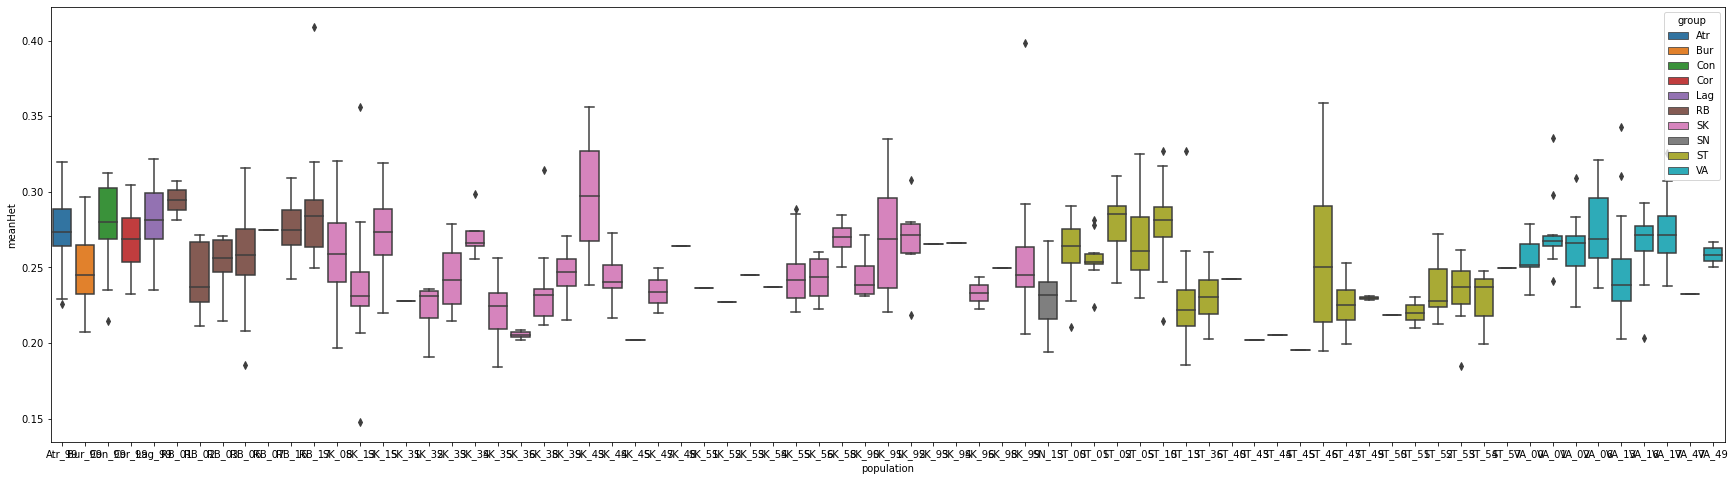

In [16]:
plt.rcParams['figure.figsize']=(30,8) #rescale figures
sns.boxplot(y='meanHet', x='population', data=het, hue='group', dodge=False)

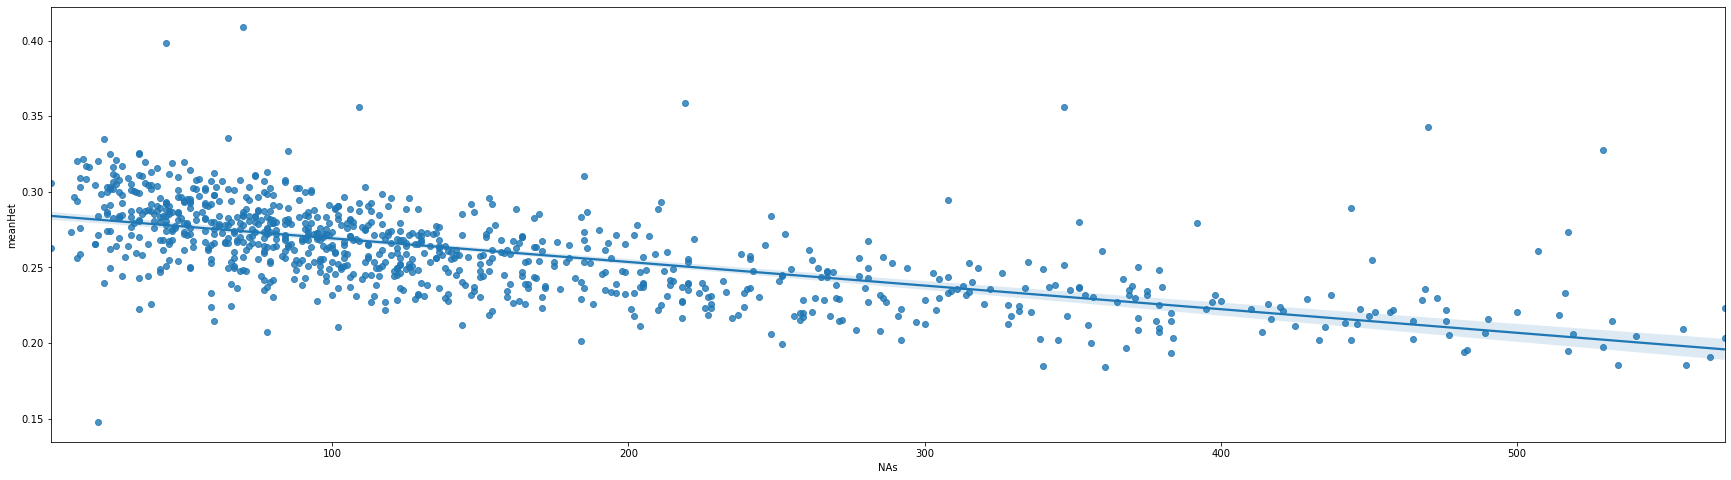

In [17]:
sns.regplot(x="NAs",y='meanHet',data=het)

In [18]:
from scipy import stats
x = het['NAs']
y = het['meanHet']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

In [19]:
r_value**2

0.40062184217901803

In [20]:
p_value

1.3882468109645416e-102

In [21]:
intercept

0.2848185349613784

In [22]:
slope

-0.00015621752276663624

## Try to replicate the linear model above

In [23]:
dataset = dataset.T

In [24]:
index = het['NAs'].idxmin()
perfect = dataset.iloc[int(index),]

In [25]:
het.iloc[144,]

V1            Lag_99_27_HFH73BBXY
meanHet                  0.271514
SE_het                 0.00907714
NAs                            21
population                 Lag_99
group                         Lag
Name: 145, dtype: object

In [26]:
dataset.iloc[144,]

NC_027300.1_2281538     0/1
NC_027300.1_2281558     0/0
NC_027300.1_2334132     0/0
NC_027300.1_2586558     0/1
NC_027300.1_2763979     0/0
                       ... 
NC_027328.1_39708377    0/1
NC_027328.1_40220819    0/1
NC_027328.1_40641207    0/0
NC_027328.1_40925550    0/1
NC_027328.1_41382929    0/0
Name: Lag_99_27_HFH73BBXY, Length: 2194, dtype: category
Categories (3, object): [0/0, 0/1, 1/1]

In [175]:
dataset2=np.asarray( dataset.copy() )

Convert genotypes to 0, 1, 2

In [176]:
idx2 = dataset2=='1/1'
idx1 = dataset2=='0/1'
idx0 = dataset2=='0/0'
idxN = np.invert( idx0|idx1|idx2 )

In [177]:
dataset2[idx0]=int(0)

In [178]:
dataset2[idx1]=int(1)

In [179]:
dataset2[idx2]=int(2)

In [180]:
dataset2[idxN]=np.nan

In [181]:
dataset2 = pd.DataFrame(dataset2, columns=dataset.columns, index=dataset.index)

Use KNN imputer

In [34]:
from sklearn.impute import KNNImputer
nan = np.nan
imputer = KNNImputer(n_neighbors=20, weights="uniform")
imputed2 = imputer.fit_transform(dataset2)

In [35]:
imputed2 = np.int16(imputed2)

In [36]:
het['knnImputed'] = 1 - np.sum( (imputed2==0)|(imputed2==2),1  )/ imputed2.shape[1]

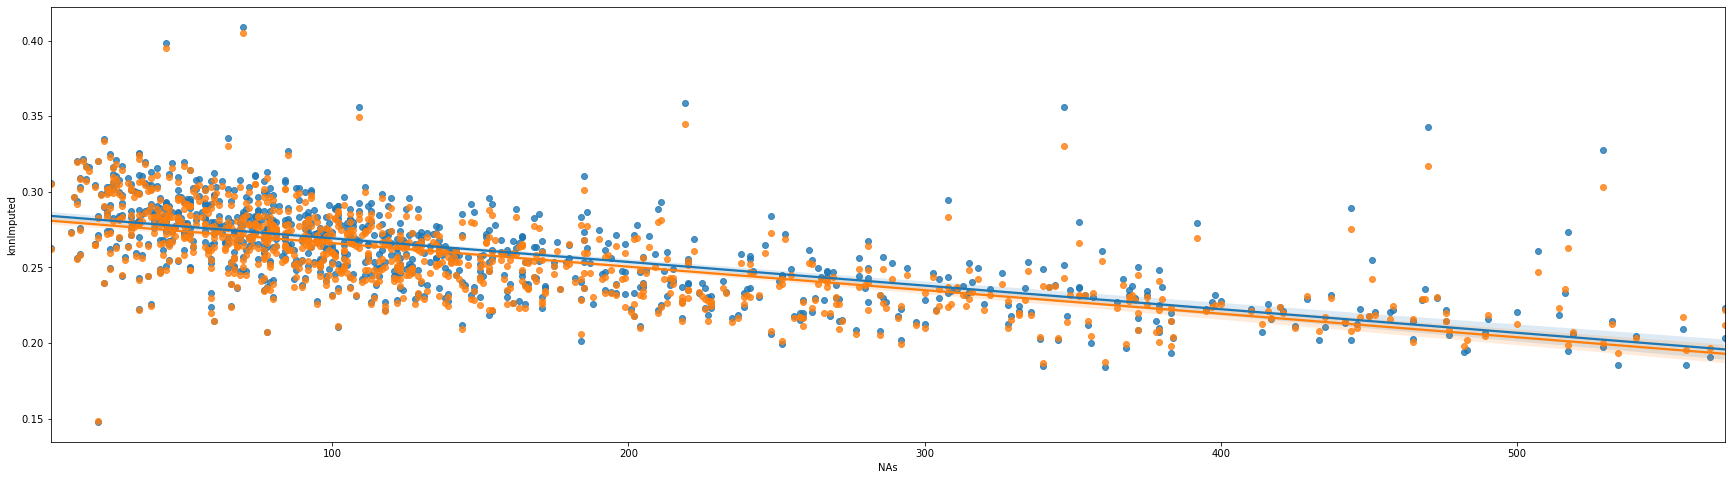

In [37]:
sns.regplot(x="NAs",y='meanHet',data=het)
sns.regplot(x="NAs",y='knnImputed',data=het)

In [153]:
#from sklearn.experimental import enable_iterative_imputer
#from sklearn.impute import IterativeImputer
#imp = IterativeImputer(max_iter=3, random_state=0)
#imp.fit(dataset2)
#IterativeImputer(random_state=0)
# the model learns that the second feature is double the first
#iterImp2 = int16(imp.transform(dataset2))

Simple binomial imputation (independently by individual)

In [42]:
dataset3 = dataset2
idx2 = dataset2==0
idx1 = dataset2==1
idx0 = dataset2==2
np.random.seed(21090)
for idx in dataset2.index:
    d = dataset2.loc[idx,:]
    allIdx = idx0.loc[idx,:]|idx1.loc[idx,:]|idx2.loc[idx,:]
    p0 = np.sum( (d==1)|(d==2) ) / np.sum(allIdx)
    dataset3.loc[ idx, np.invert(allIdx) ] = np.random.binomial(n=2, p=p0, 
                                                                size=np.sum(np.invert(allIdx)))

In [43]:
dataset3

NC_027300.1_2281538 NC_027300.1_2281558  \
Atr_99_01_HFGGJBBXY                   2                   2   
Atr_99_02_HFGGJBBXY                   1                   1   
Atr_99_03_HFGGJBBXY                   2                   1   
Atr_99_04_HFGGJBBXY                   1                   1   
Atr_99_05_HFGGJBBXY                   0                   0   
...                                 ...                 ...   
VA_17_8_HFH73BBXY                     2                   2   
VA_17_9_HFH73BBXY                     2                   2   
VA_47_05_HFH73BBXY                    1                   0   
VA_49_01_HFH73BBXY                    2                   0   
VA_49_09_HFH73BBXY                    1                   0   

                    NC_027300.1_2334132 NC_027300.1_2586558  \
Atr_99_01_HFGGJBBXY                   0                   1   
Atr_99_02_HFGGJBBXY                   0                   0   
Atr_99_03_HFGGJBBXY                   0                   1   
Atr_99_04_HFGGJBBXY                   1                   1   
Atr_99_05_HFGGJBBXY                   0                   0   
...                                 ...                 ...   
VA_17_8_HFH73BBXY                     0                   0   
VA_17_9_HFH73BBXY                     0                   2   
VA_47_05_HFH73BBXY                    1                   0   
VA_49_01_HFH73BBXY                    1                   0   
VA_49_09_HFH73BBXY                    0                   0   

                    NC_027300.1_2763979 NC_027300.1_2763981  \
Atr_99_01_HFGGJBBXY                   0                   0   
Atr_99_02_HFGGJBBXY                   1                   1   
Atr_99_03_HFGGJBBXY                   0                   0   
Atr_99_04_HFGGJBBXY                   1                   1   
Atr_99_05_HFGGJBBXY                   0                   0   
...                                 ...                 ...   
VA_17_8_HFH73BBXY                     0                   0   
VA_17_9_HFH73BBXY                     0                   0   
VA_47_05_HFH73BBXY                    0                   0   
VA_49_01_HFH73BBXY                    0                   0   
VA_49_09_HFH73BBXY                    0                   0   

                    NC_027300.1_2763997 NC_027300.1_4451367  \
Atr_99_01_HFGGJBBXY                   1                   1   
Atr_99_02_HFGGJBBXY                   0                   1   
Atr_99_03_HFGGJBBXY                   2                   2   
Atr_99_04_HFGGJBBXY                   0                   0   
Atr_99_05_HFGGJBBXY                   1                   1   
...                                 ...                 ...   
VA_17_8_HFH73BBXY                     0                   2   
VA_17_9_HFH73BBXY                     1                   1   
VA_47_05_HFH73BBXY                    0                   2   
VA_49_01_HFH73BBXY                    0                   2   
VA_49_09_HFH73BBXY                    0                   2   

                    NC_027300.1_4451529 NC_027300.1_7784927  ...  \
Atr_99_01_HFGGJBBXY                   0                   0  ...   
Atr_99_02_HFGGJBBXY                   1                   0  ...   
Atr_99_03_HFGGJBBXY                   2                   0  ...   
Atr_99_04_HFGGJBBXY                   0                   0  ...   
Atr_99_05_HFGGJBBXY                   1                   0  ...   
...                                 ...                 ...  ...   
VA_17_8_HFH73BBXY                     0                   0  ...   
VA_17_9_HFH73BBXY                     2                   0  ...   
VA_47_05_HFH73BBXY                    0                   0  ...   
VA_49_01_HFH73BBXY                    1                   0  ...   
VA_49_09_HFH73BBXY                    1                   1  ...   

                    NC_027328.1_36316246 NC_027328.1_36316252  \
Atr_99_01_HFGGJBBXY                    0                    0   
Atr_99_02_HFGGJBBXY                    0     

In [44]:
1-np.sum( (dataset3==0)|(dataset3==2),1  )/ dataset3.shape[1]

Atr_99_01_HFGGJBBXY    0.289426
Atr_99_02_HFGGJBBXY    0.278031
Atr_99_03_HFGGJBBXY    0.280310
Atr_99_04_HFGGJBBXY    0.276664
Atr_99_05_HFGGJBBXY    0.324066
                         ...   
VA_17_8_HFH73BBXY      0.269371
VA_17_9_HFH73BBXY      0.286235
VA_47_05_HFH73BBXY     0.255697
VA_49_01_HFH73BBXY     0.270283
VA_49_09_HFH73BBXY     0.289426
Length: 906, dtype: float64

In [45]:
het['binomImputed'] = np.float32(1 - np.sum( (dataset3==0)|(dataset3==2),1  )/dataset3.shape[1])

Text(0.5, 1.0, 'Heterozygosity in function of NAs\nwith different imputation methods')

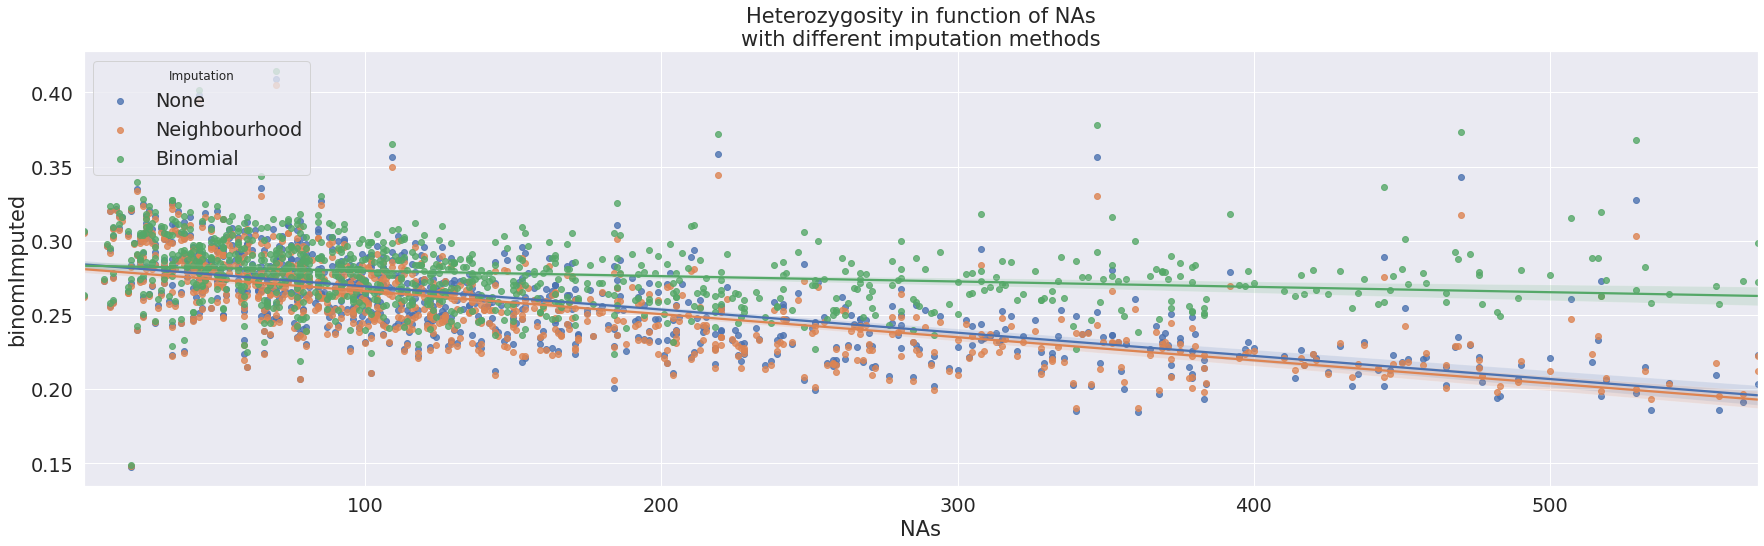

In [46]:
sns.set(font_scale=1.75)
f, ax = plt.subplots(1,1)
sns.regplot(x="NAs",y='meanHet',data=het, ax=ax, label='None')
sns.regplot(x="NAs",y='knnImputed',data=het, ax=ax, label='Neighbourhood')
sns.regplot(x="NAs",y='binomImputed',data=het, ax=ax, label='Binomial')
plt.legend(title='Imputation', loc='upper left')
ax.set_title("Heterozygosity in function of NAs\nwith different imputation methods")

In [47]:
dataset3.to_csv('./dataset_binomial.csv', sep='\t')

In [48]:
het.to_csv('./heterozigosity_table.csv', sep='\t')

Binomial imputation (population by population)

In [182]:
dataset4 = dataset2.copy()

In [183]:
multiIndex = []
for i in dataset4.index:
    multiIndex.append( ('_'.join(i.split('_')[0:2]), i) )

In [184]:
index = pd.MultiIndex.from_tuples(multiIndex)

In [185]:
dataset4.index = multiIndex #change index to tuples

In [186]:
dataset4 = dataset4.reindex(index) #use the new multiindex to map tuples to multiindices

In [187]:
dataset4.loc['Atr_99']

NC_027300.1_2281538 NC_027300.1_2281558  \
Atr_99_01_HFGGJBBXY                   2                   2   
Atr_99_02_HFGGJBBXY                   1                   1   
Atr_99_03_HFGGJBBXY                   2                   1   
Atr_99_04_HFGGJBBXY                   1                   1   
Atr_99_05_HFGGJBBXY                   0                   0   
Atr_99_06_HFGGJBBXY                   2                   1   
Atr_99_07_HFGGJBBXY                   1                   0   
Atr_99_08_HFGGJBBXY                   1                   0   
Atr_99_09_HFGGJBBXY                   2                   2   
Atr_99_10_HFGGJBBXY                   1                   0   
Atr_99_11_HFGGJBBXY                   1                   1   
Atr_99_12_HFGGJBBXY                   1                   0   
Atr_99_13_HFGGJBBXY                   1                   0   
Atr_99_14_HFGGJBBXY                   0                   0   
Atr_99_15_HFGGJBBXY                   0                   0   
Atr_99_16_HFGGJBBXY                   1                   0   
Atr_99_17_HFGGJBBXY                   1                   0   
Atr_99_18_HFGGJBBXY                   0                   0   
Atr_99_19_HFGGJBBXY                   0                   0   
Atr_99_20_HFGGJBBXY                   0                   0   
Atr_99_21_HFGGJBBXY                   1                   1   
Atr_99_22_HFGGJBBXY                   2                   0   
Atr_99_23_HFGGJBBXY                   1                   0   
Atr_99_24_HFGGJBBXY                   0                   0   
Atr_99_25_HFGGJBBXY                   1                   0   
Atr_99_26_HFGGJBBXY                   1                   0   
Atr_99_28_HFGGJBBXY                 NaN                 NaN   
Atr_99_29_HFGGJBBXY                   0                   0   
Atr_99_30_HFGGJBBXY                   1                   0   
Atr_99_31_HFGGJBBXY                   0                   0   

                    NC_027300.1_2334132 NC_027300.1_2586558  \
Atr_99_01_HFGGJBBXY                   0                   1   
Atr_99_02_HFGGJBBXY                   0                   0   
Atr_99_03_HFGGJBBXY                   0                   1   
Atr_99_04_HFGGJBBXY                   1                   1   
Atr_99_05_HFGGJBBXY                   0                   0   
Atr_99_06_HFGGJBBXY                   0                   0   
Atr_99_07_HFGGJBBXY                   0                   1   
Atr_99_08_HFGGJBBXY                   0                   1   
Atr_99_09_HFGGJBBXY                   0                   0   
Atr_99_10_HFGGJBBXY                   0                   1   
Atr_99_11_HFGGJBBXY                   0                   0   
Atr_99_12_HFGGJBBXY                   0                   0   
Atr_99_13_HFGGJBBXY                   1                   0   
Atr_99_14_HFGGJBBXY                   0                   0   
Atr_99_15_HFGGJBBXY                   0                   0   
Atr_99_16_HFGGJBBXY                   0                   1   
Atr_99_17_HFGGJBBXY                   0                   1   
Atr_99_18_HFGGJBBXY                   0                   0   
Atr_99_19_HFGGJBBXY                   0                   0   
Atr_99_20_HFGGJBBXY                   0                   0   
Atr_99_21_HFGGJBBXY                   1                   1   
Atr_99_22_HFGGJBBXY                   0                   0   
Atr_99_23_HFGGJBBXY                   0                   1   
Atr_99_24_HFGGJBBXY                   0                   0   
Atr_99_25_HFGGJBBXY                   0                   0   
Atr_99_26_HFGGJBBXY                   0                   0   
Atr_99_28_HFGGJBBXY                   1                   1   
Atr_99_29_HFGGJBBXY                   0                   1   
Atr_99_30_HFGGJBBXY                   0                   1   
Atr_99_31_HFGGJBBXY                   0                   0   

                    NC_027300.1_2763979 NC_027300.1_2763981  \
Atr_99_01_HFGGJBBXY                   0          

In [188]:
idx2 = dataset4==0
idx1 = dataset4==1
idx0 = dataset4==2

In [189]:
dataset4

NC_027300.1_2281538 NC_027300.1_2281558  \
Atr_99 Atr_99_01_HFGGJBBXY                   2                   2   
       Atr_99_02_HFGGJBBXY                   1                   1   
       Atr_99_03_HFGGJBBXY                   2                   1   
       Atr_99_04_HFGGJBBXY                   1                   1   
       Atr_99_05_HFGGJBBXY                   0                   0   
...                                        ...                 ...   
VA_17  VA_17_8_HFH73BBXY                     2                   2   
       VA_17_9_HFH73BBXY                     2                   2   
VA_47  VA_47_05_HFH73BBXY                    1                   0   
VA_49  VA_49_01_HFH73BBXY                    2                   0   
       VA_49_09_HFH73BBXY                    1                   0   

                           NC_027300.1_2334132 NC_027300.1_2586558  \
Atr_99 Atr_99_01_HFGGJBBXY                   0                   1   
       Atr_99_02_HFGGJBBXY                   0                   0   
       Atr_99_03_HFGGJBBXY                   0                   1   
       Atr_99_04_HFGGJBBXY                   1                   1   
       Atr_99_05_HFGGJBBXY                   0                   0   
...                                        ...                 ...   
VA_17  VA_17_8_HFH73BBXY                     0                   0   
       VA_17_9_HFH73BBXY                     0                   2   
VA_47  VA_47_05_HFH73BBXY                    1                   0   
VA_49  VA_49_01_HFH73BBXY                    1                   0   
       VA_49_09_HFH73BBXY                    0                 NaN   

                           NC_027300.1_2763979 NC_027300.1_2763981  \
Atr_99 Atr_99_01_HFGGJBBXY                   0                   0   
       Atr_99_02_HFGGJBBXY                   1                   1   
       Atr_99_03_HFGGJBBXY                   0                   0   
       Atr_99_04_HFGGJBBXY                   1                   1   
       Atr_99_05_HFGGJBBXY                   0                   0   
...                                        ...                 ...   
VA_17  VA_17_8_HFH73BBXY                     0                   0   
       VA_17_9_HFH73BBXY                     0                   0   
VA_47  VA_47_05_HFH73BBXY                    0                   0   
VA_49  VA_49_01_HFH73BBXY                    0                   0   
       VA_49_09_HFH73BBXY                    0                   0   

                           NC_027300.1_2763997 NC_027300.1_4451367  \
Atr_99 Atr_99_01_HFGGJBBXY                   1                   1   
       Atr_99_02_HFGGJBBXY                   0                   1   
       Atr_99_03_HFGGJBBXY                   2                   2   
       Atr_99_04_HFGGJBBXY                   0                   0   
       Atr_99_05_HFGGJBBXY                   1                   1   
...                                        ...                 ...   
VA_17  VA_17_8_HFH73BBXY                     0                   2   
       VA_17_9_HFH73BBXY                     1                   1   
VA_47  VA_47_05_HFH73BBXY                    0                   2   
VA_49  VA_49_01_HFH73BBXY                    0                   2   
       VA_49_09_HFH73BBXY                    0                   2   

                           NC_027300.1_4451529 NC_027300.1_7784927  ...  \
Atr_99 Atr_99_01_HFGGJBBXY                   0                   0  ...   
       Atr_99_02_HFGGJBBXY                   1                   0  ...   
       Atr_99_03_HFGGJBBXY                   2                   0  ...   
       Atr_99_04_HFGGJBBXY                   0                   0  ...   
       Atr_99_05_HFGGJBBXY                   1                   0  ...   
...                                        ...                 ...  ...   
VA_17  VA_17_8_HFH73BBXY                     0                   0  ...   
       VA_17_9_HFH73BBXY                     2                 

In [200]:
dataset5.loc[ pop, idx,  ]

NC_027300.1_2281538     1
NC_027300.1_2281558     0
NC_027300.1_2334132     0
NC_027300.1_2586558     0
NC_027300.1_2763979     0
                       ..
NC_027328.1_39708377    1
NC_027328.1_40220819    0
NC_027328.1_40641207    0
NC_027328.1_40925550    0
NC_027328.1_41382929    1
Name: (VA_49, VA_49_09_HFH73BBXY), Length: 2194, dtype: object

In [197]:
np.ndarray.tolist(singleIndiv)

[2,
 2,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 1,
 0,
 1,
 1,
 0,
 2,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 2,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 2,
 2,
 2,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 2,
 1,
 1,
 0,
 0,
 1,
 2,
 1,
 0,
 2,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 2,
 1,
 0,
 0,
 0,
 2,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 2,
 0,
 0,
 2,
 1,
 0,
 0,
 2,
 2,
 1,
 0,
 0,
 1,
 0,
 0,
 2,
 0,
 2,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 0,
 2,
 0,
 1,
 1,
 2,
 2,
 0,
 0,
 0,
 1,
 2,
 0,
 2,
 2,
 0,
 1,
 0,
 2,
 0,
 0,
 1,
 0,
 2,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 2,
 1,
 0,


In [199]:
np.random.seed(21090)
population = np.unique( [i[0] for i in dataset4.index] )
dataset5 = dataset4.copy()
for pop in population:
    d = dataset4.loc[pop]
    idx2 = d==0
    idx1 = d==1
    idx0 = d==2
    allIdx = idx0|idx1|idx2
    p0 = np.sum( np.array((d==1)|(d==2)), axis=None ) / np.sum(np.array(allIdx), axis=None)
    for idx in dataset4.loc[pop].index:
        singleIndiv = np.hstack(np.array(dataset4.loc[ pop, idx, : ].copy()))
        idx2 = singleIndiv==0
        idx1 = singleIndiv==1
        idx0 = singleIndiv==2
        allIdx = idx0|idx1|idx2
        where = np.where(np.invert(np.array(allIdx)))      
        singleIndiv[where] = np.random.binomial(n=2, p=p0, size=len(where))
        dataset5.loc[ pop, idx,  ] = np.ndarray.tolist(singleIndiv.copy())
        print(singleIndiv)

[2 2 0 ... 2 0 0]
[1 1 0 ... 0 1 0]
[2 1 0 ... 0 1 0]
[1 1 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[2 1 0 ... 0 1 0]
[1 0 0 ... 0 1 0]
[1 0 0 ... 0 1 0]
[2 2 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 1 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 1 ... 0 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 0 1 0]
[1 0 0 ... 0 0 0]
[1 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 1 1 ... 0 1 0]
[2 0 0 ... 0 1 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[1 0 0 ... 0 1 0]
[2 2 1 ... 0 0 0]
[0 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[2 1 2 ... 2 0 0]
[2 2 2 ... 1 0 0]
[2 2 1 ... 1 0 0]
[2 2 1 ... 1 0 0]
[2 0 1 ... 0 1 0]
[2 1 1 ... 0 1 0]
[2 2 0 ... 1 0 0]
[2 2 0 ... 1 0 0]
[2 2 2 ... 1 0 0]
[2 1 0 ... 0 1 0]
[2 2 0 ... 0 1 0]
[2 2 1 ... 1 0 0]
[0 0 0 ... 0 1 0]
[2 2 0 ... 0 1 0]
[2 2 0 ... 1 0 0]
[2 1 1 ... 0 0 0]
[2 2 1 ... 0 0 0]
[0 0 2 ... 2 0 0]
[2 0 1 ... 1 1 0]
[2 0 2 ... 2 0 0]
[2 2 0 ... 1 0 0]
[2 2 2 ... 2 0 0]
[2 2 0 ... 1 0 0]
[2 2 1 ... 1 0 0]
[2 2 1 ... 1 0 0]
[1 2 2 ...

[2 1 0 ... 0 0 0]
[2 2 0 ... 0 1 1]
[1 0 1 ... 0 0 0]
[2 2 0 ... 0 0 0]
[1 1 0 ... 0 0 0]
[2 0 0 ... 0 0 0]
[2 2 0 ... 0 0 0]
[2 2 0 ... 0 0 0]
[1 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[2 1 0 ... 0 0 0]
[2 0 0 ... 0 0 0]
[2 2 0 ... 0 0 1]
[2 2 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[2 2 0 ... 2 0 0]
[0 0 0 ... 0 0 0]
[1 1 1 ... 0 0 0]
[2 2 0 ... 0 1 0]
[1 1 0 ... 0 1 0]
[2 1 0 ... 1 0 1]
[0 0 0 ... 1 0 0]
[2 2 0 ... 0 0 1]
[0 0 0 ... 0 0 0]
[2 0 0 ... 0 0 0]
[2 0 0 ... 0 0 0]
[1 0 0 ... 0 0 0]
[2 2 0 ... 0 0 0]
[2 2 0 ... 0 0 0]
[2 0 0 ... 0 1 0]
[0 0 0 ... 0 0 0]
[2 0 0 ... 0 0 0]
[2 1 0 ... 0 1 0]
[2 0 0 ... 0 0 0]
[1 0 1 ... 1 1 0]
[2 2 0 ... 0 0 0]
[1 1 0 ... 0 0 0]
[1 0 1 ... 1 0 0]
[1 0 1 ... 1 0 0]
[0 0 0 ... 0 0 1]
[2 2 0 ... 0 0 0]
[0 0 1 ... 2 1 0]
[0 0 1 ... 0 1 0]
[2 2 2 ... 0 1 0]
[2 1 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[2 1 0 ... 0 0 0]
[1 1 1 ... 0 1 0]
[2 0 0 ... 0 0 0]
[2 2 0 ... 0 0 0]
[2 0 0 ... 1 0 0]
[2 0 0 ... 0 0 1]
[2 2 0 ... 0 0 1]
[2 1 0 ... 0 0 0]
[2 0 0 ... 0 0 0]
[2 1 0 ...

In [201]:
dataset5

NC_027300.1_2281538 NC_027300.1_2281558  \
Atr_99 Atr_99_01_HFGGJBBXY                   2                   2   
       Atr_99_02_HFGGJBBXY                   1                   1   
       Atr_99_03_HFGGJBBXY                   2                   1   
       Atr_99_04_HFGGJBBXY                   1                   1   
       Atr_99_05_HFGGJBBXY                   0                   0   
...                                        ...                 ...   
VA_17  VA_17_8_HFH73BBXY                     2                   2   
       VA_17_9_HFH73BBXY                     2                   2   
VA_47  VA_47_05_HFH73BBXY                    1                   0   
VA_49  VA_49_01_HFH73BBXY                    2                   0   
       VA_49_09_HFH73BBXY                    1                   0   

                           NC_027300.1_2334132 NC_027300.1_2586558  \
Atr_99 Atr_99_01_HFGGJBBXY                   0                   1   
       Atr_99_02_HFGGJBBXY                   0                   0   
       Atr_99_03_HFGGJBBXY                   0                   1   
       Atr_99_04_HFGGJBBXY                   1                   1   
       Atr_99_05_HFGGJBBXY                   0                   0   
...                                        ...                 ...   
VA_17  VA_17_8_HFH73BBXY                     0                   0   
       VA_17_9_HFH73BBXY                     0                   2   
VA_47  VA_47_05_HFH73BBXY                    1                   0   
VA_49  VA_49_01_HFH73BBXY                    1                   0   
       VA_49_09_HFH73BBXY                    0                   0   

                           NC_027300.1_2763979 NC_027300.1_2763981  \
Atr_99 Atr_99_01_HFGGJBBXY                   0                   0   
       Atr_99_02_HFGGJBBXY                   1                   1   
       Atr_99_03_HFGGJBBXY                   0                   0   
       Atr_99_04_HFGGJBBXY                   1                   1   
       Atr_99_05_HFGGJBBXY                   0                   0   
...                                        ...                 ...   
VA_17  VA_17_8_HFH73BBXY                     0                   0   
       VA_17_9_HFH73BBXY                     0                   0   
VA_47  VA_47_05_HFH73BBXY                    0                   0   
VA_49  VA_49_01_HFH73BBXY                    0                   0   
       VA_49_09_HFH73BBXY                    0                   0   

                           NC_027300.1_2763997 NC_027300.1_4451367  \
Atr_99 Atr_99_01_HFGGJBBXY                   1                   1   
       Atr_99_02_HFGGJBBXY                   0                   1   
       Atr_99_03_HFGGJBBXY                   2                   2   
       Atr_99_04_HFGGJBBXY                   0                   0   
       Atr_99_05_HFGGJBBXY                   1                   1   
...                                        ...                 ...   
VA_17  VA_17_8_HFH73BBXY                     0                   2   
       VA_17_9_HFH73BBXY                     1                   1   
VA_47  VA_47_05_HFH73BBXY                    0                   2   
VA_49  VA_49_01_HFH73BBXY                    0                   2   
       VA_49_09_HFH73BBXY                    0                   2   

                           NC_027300.1_4451529 NC_027300.1_7784927  ...  \
Atr_99 Atr_99_01_HFGGJBBXY                   0                   0  ...   
       Atr_99_02_HFGGJBBXY                   1                   0  ...   
       Atr_99_03_HFGGJBBXY                   2                   0  ...   
       Atr_99_04_HFGGJBBXY                   0                   0  ...   
       Atr_99_05_HFGGJBBXY                   1                   0  ...   
...                                        ...                 ...  ...   
VA_17  VA_17_8_HFH73BBXY                     0                   0  ...   
       VA_17_9_HFH73BBXY                     2                 

In [202]:
1-np.sum( (dataset5==0)|(dataset5==2),1  )/ dataset5.shape[1]

Atr_99  Atr_99_01_HFGGJBBXY    0.268915
        Atr_99_02_HFGGJBBXY    0.261167
        Atr_99_03_HFGGJBBXY    0.292616
        Atr_99_04_HFGGJBBXY    0.259344
        Atr_99_05_HFGGJBBXY    0.331358
                                 ...   
VA_17   VA_17_8_HFH73BBXY      0.244303
        VA_17_9_HFH73BBXY      0.257065
VA_47   VA_47_05_HFH73BBXY     0.207384
VA_49   VA_49_01_HFH73BBXY     0.289426
        VA_49_09_HFH73BBXY     0.207840
Length: 906, dtype: float64

In [203]:
het['binomPopulation'] = np.float32(1 - np.sum( (dataset5==0)|(dataset5==2),1  )/dataset5.shape[1])

Text(0.5, 1.0, 'Heterozygosity in function of NAs\nwith different imputation methods')

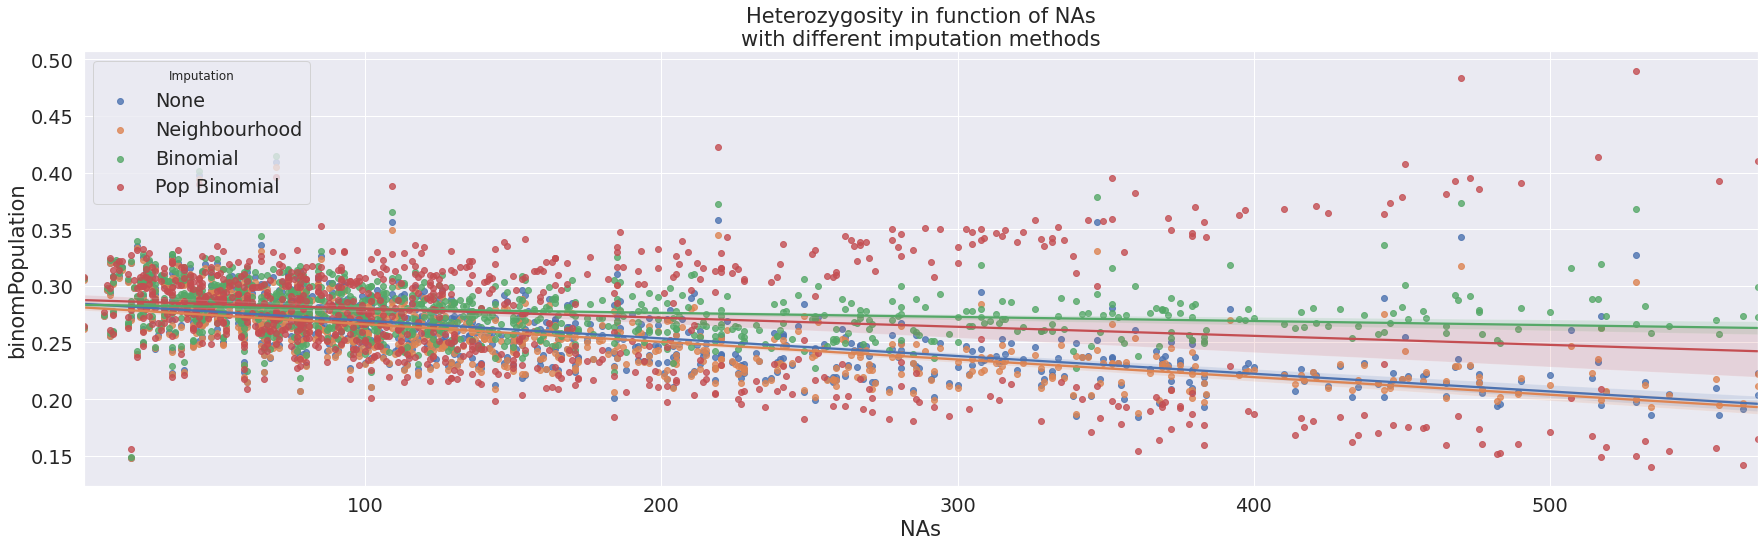

In [204]:
sns.set(font_scale=1.75)
f, ax = plt.subplots(1,1)
sns.regplot(x="NAs",y='meanHet',data=het, ax=ax, label='None')
sns.regplot(x="NAs",y='knnImputed',data=het, ax=ax, label='Neighbourhood')
sns.regplot(x="NAs",y='binomImputed',data=het, ax=ax, label='Binomial')
sns.regplot(x="NAs",y='binomPopulation',data=het, ax=ax, label='Pop Binomial')
plt.legend(title='Imputation', loc='upper left')
ax.set_title("Heterozygosity in function of NAs\nwith different imputation methods")

In [205]:
dataset5.to_csv('./dataset_population_binomial.csv', sep='\t')

In [206]:
het.to_csv('./heterozigosity_table.csv', sep='\t')

In [232]:
het['year'] = pd.Categorical([i.split('_')[1] for i in het['V1']])

In [222]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X = pca.fit_transform(dataset3)

In [223]:
PCA(n_components=3)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.05306085 0.01943924 0.0135511 ]
[195.7657294  118.49205661  98.9320078 ]


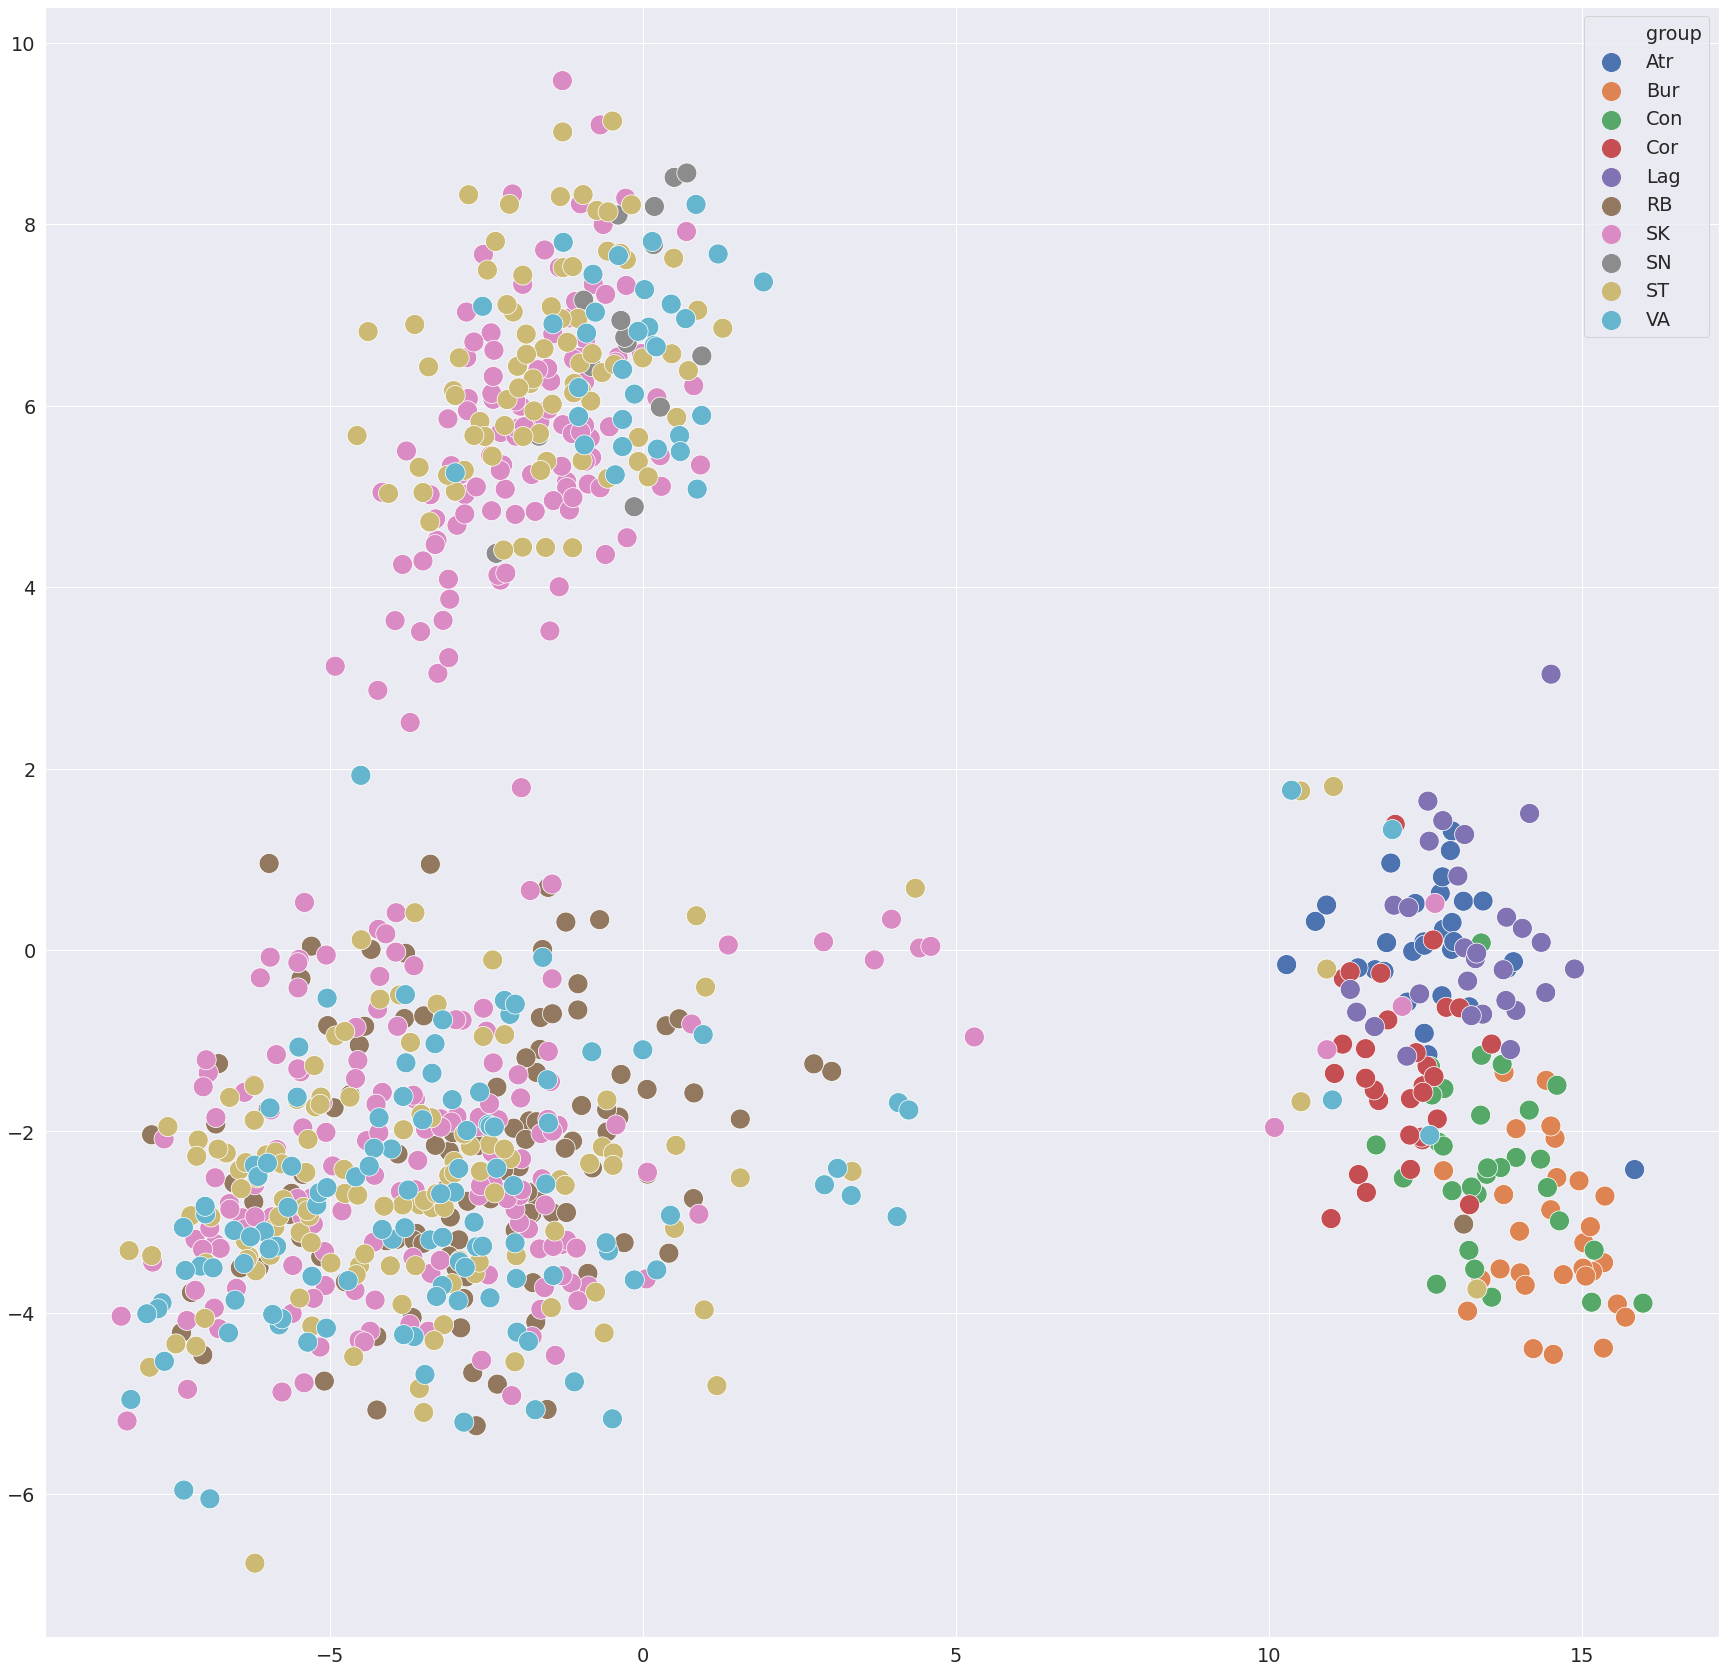

In [224]:
plt.rcParams['figure.figsize']=(30,30)
sns.scatterplot(X[:,0],X[:,1], hue=het['group'], s=400)
plt.legend(loc='upper right', markerscale=3., scatterpoints=1)

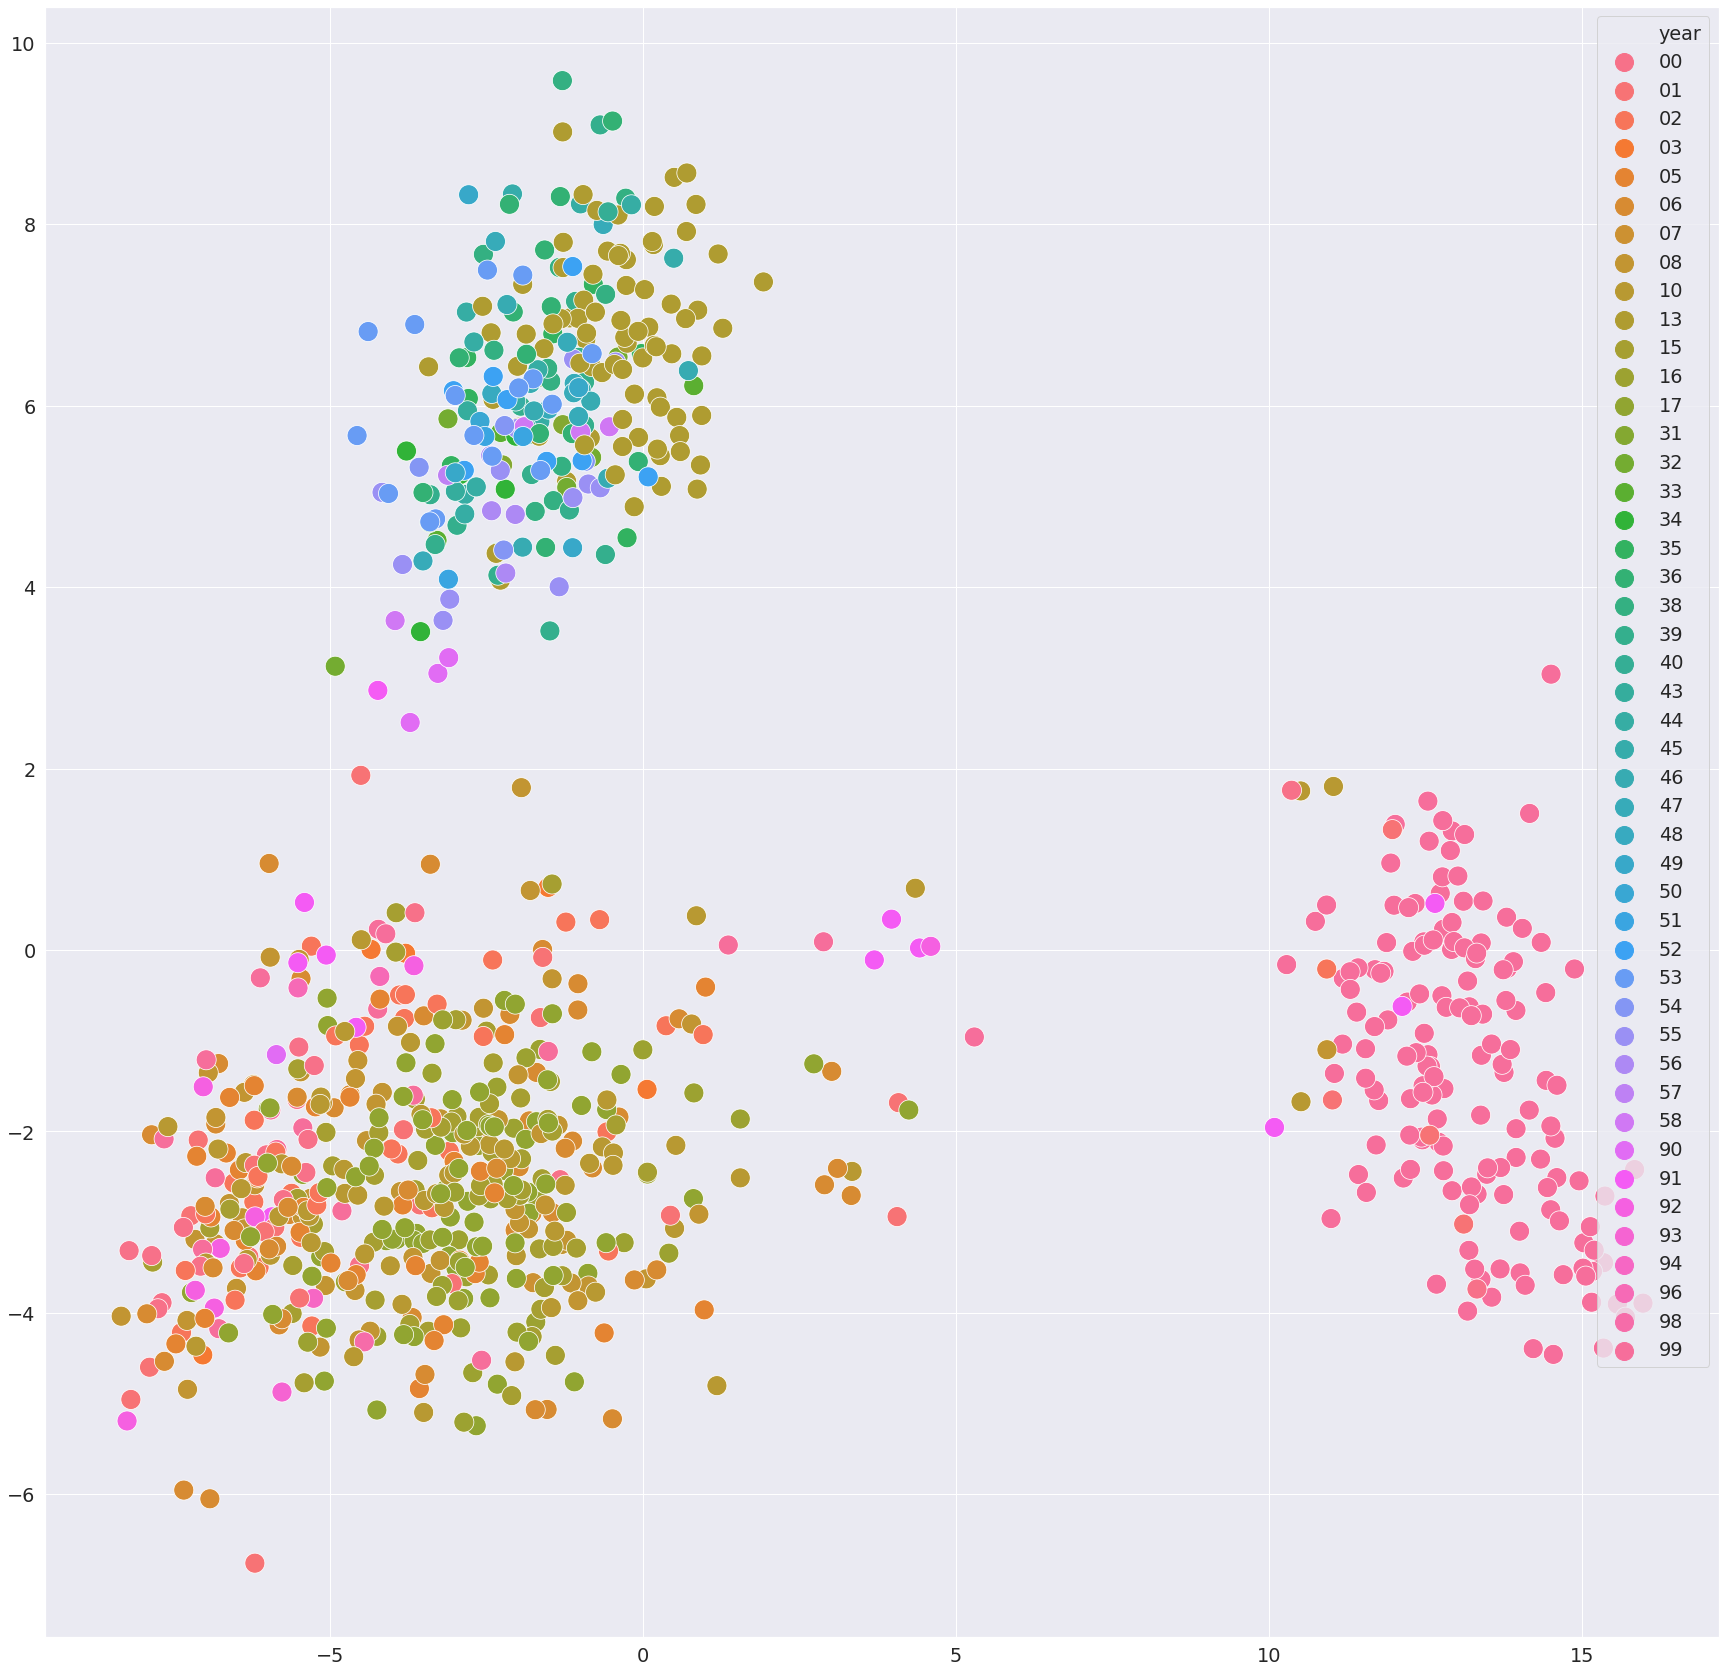

In [231]:
plt.rcParams['figure.figsize']=(30,30)
sns.scatterplot(X[:,0],X[:,1], hue=het['year'], s=400)
plt.legend(loc='upper right', markerscale=3., scatterpoints=1)

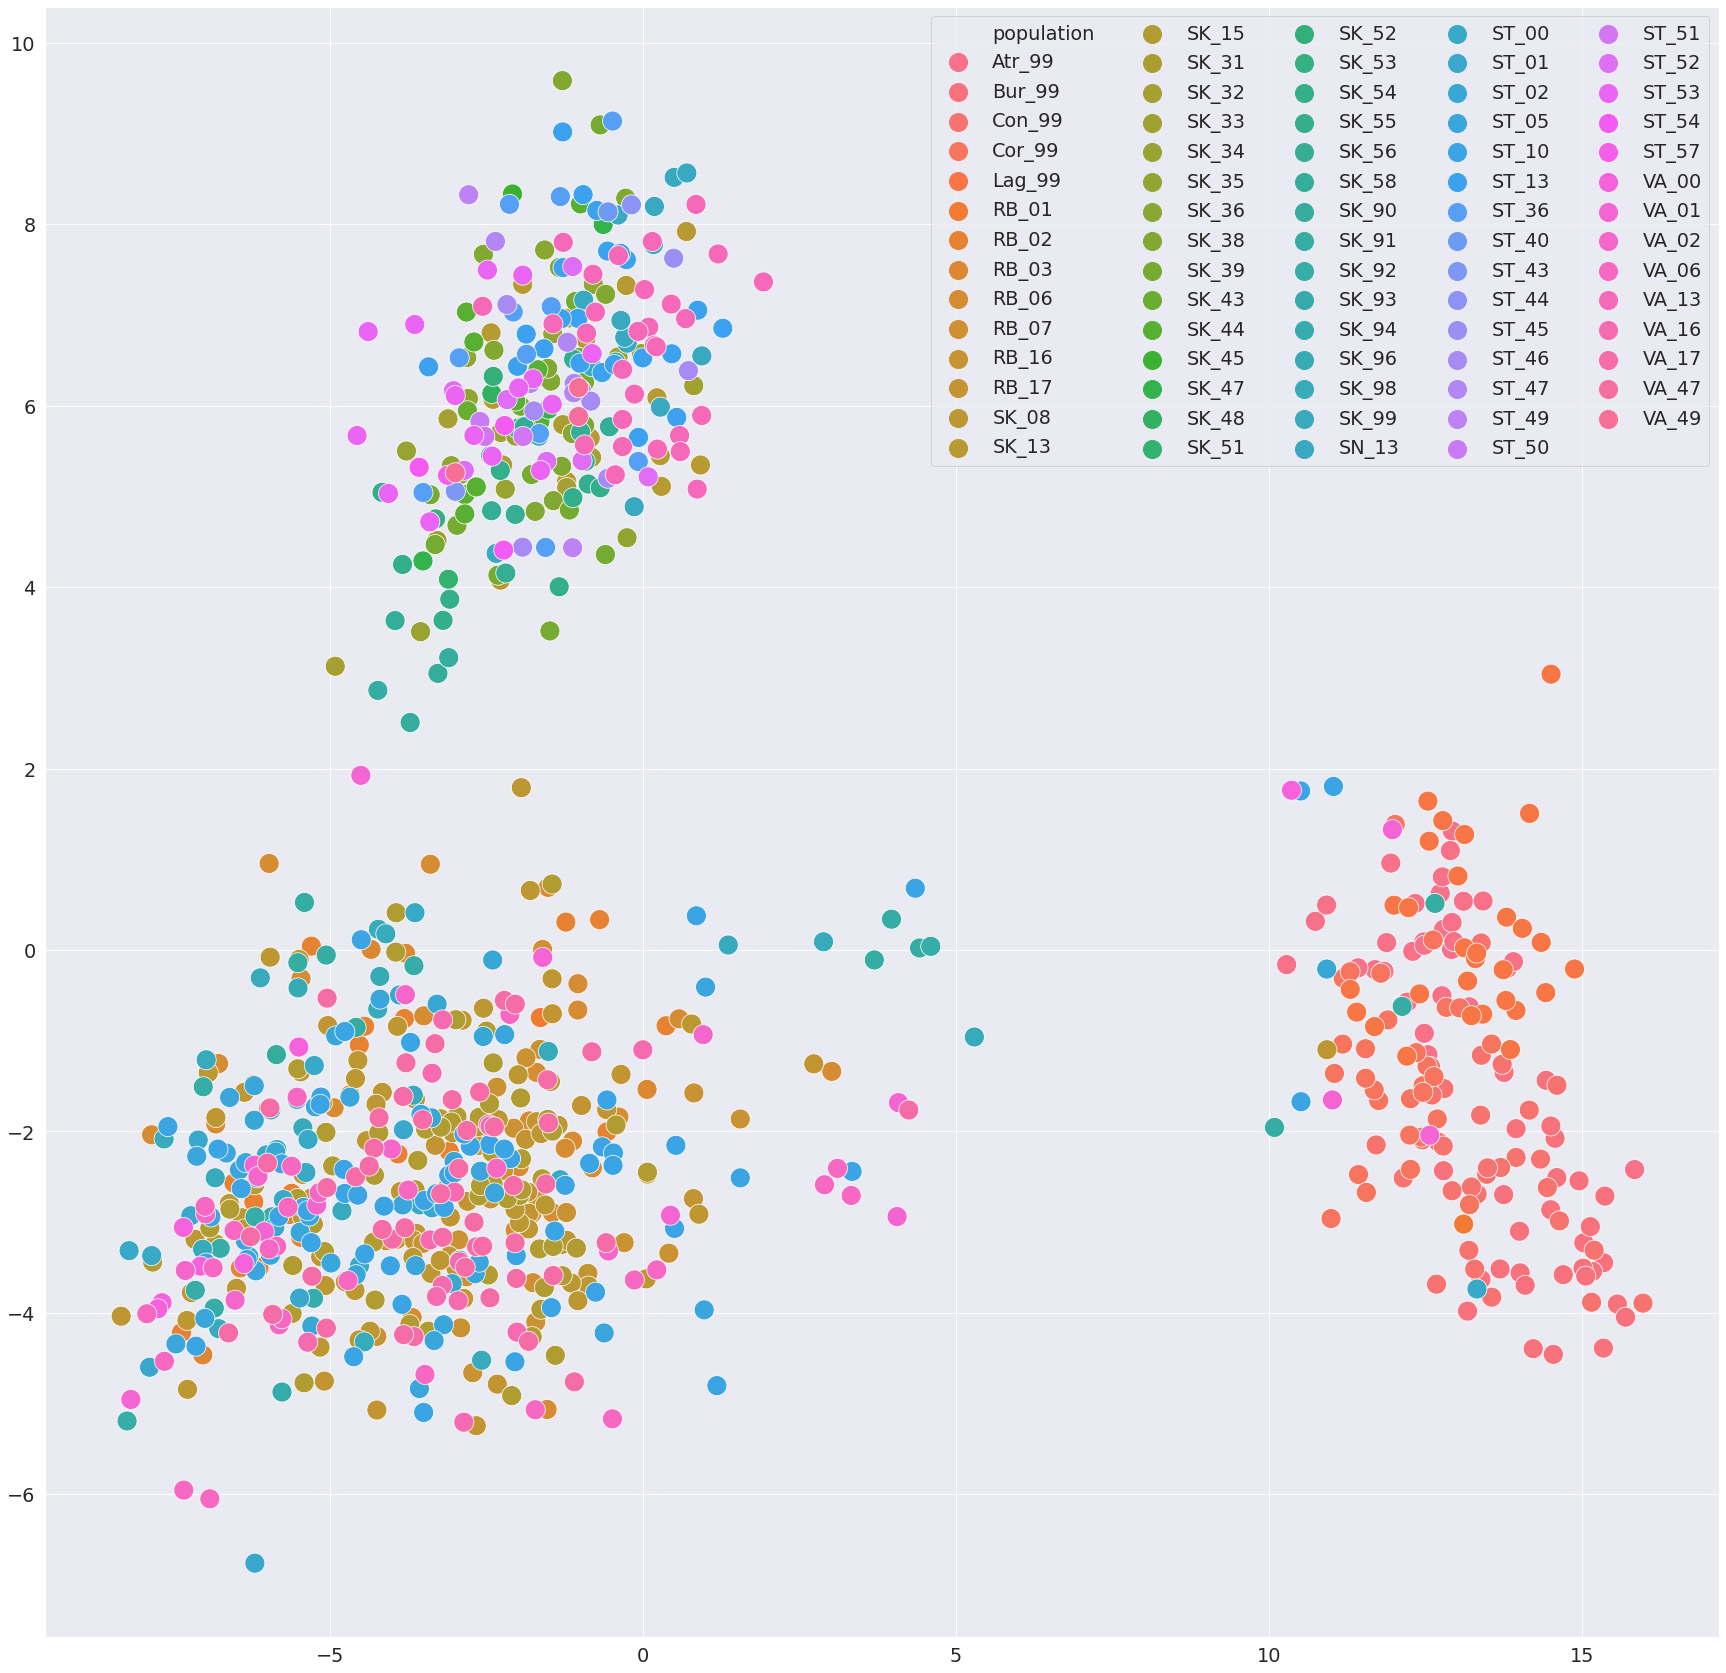

In [225]:
plt.rcParams['figure.figsize']=(30,30)
ax=sns.scatterplot(X[:,0],X[:,1], hue=het['population'], s=400)
plt.legend(loc='upper right', ncol=5, markerscale=3., scatterpoints=1)

In [211]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X = pca.fit_transform(dataset5)

In [212]:
PCA(n_components=3)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.0528539  0.02890379 0.01881942]
[196.04857395 144.97816251 116.98449037]


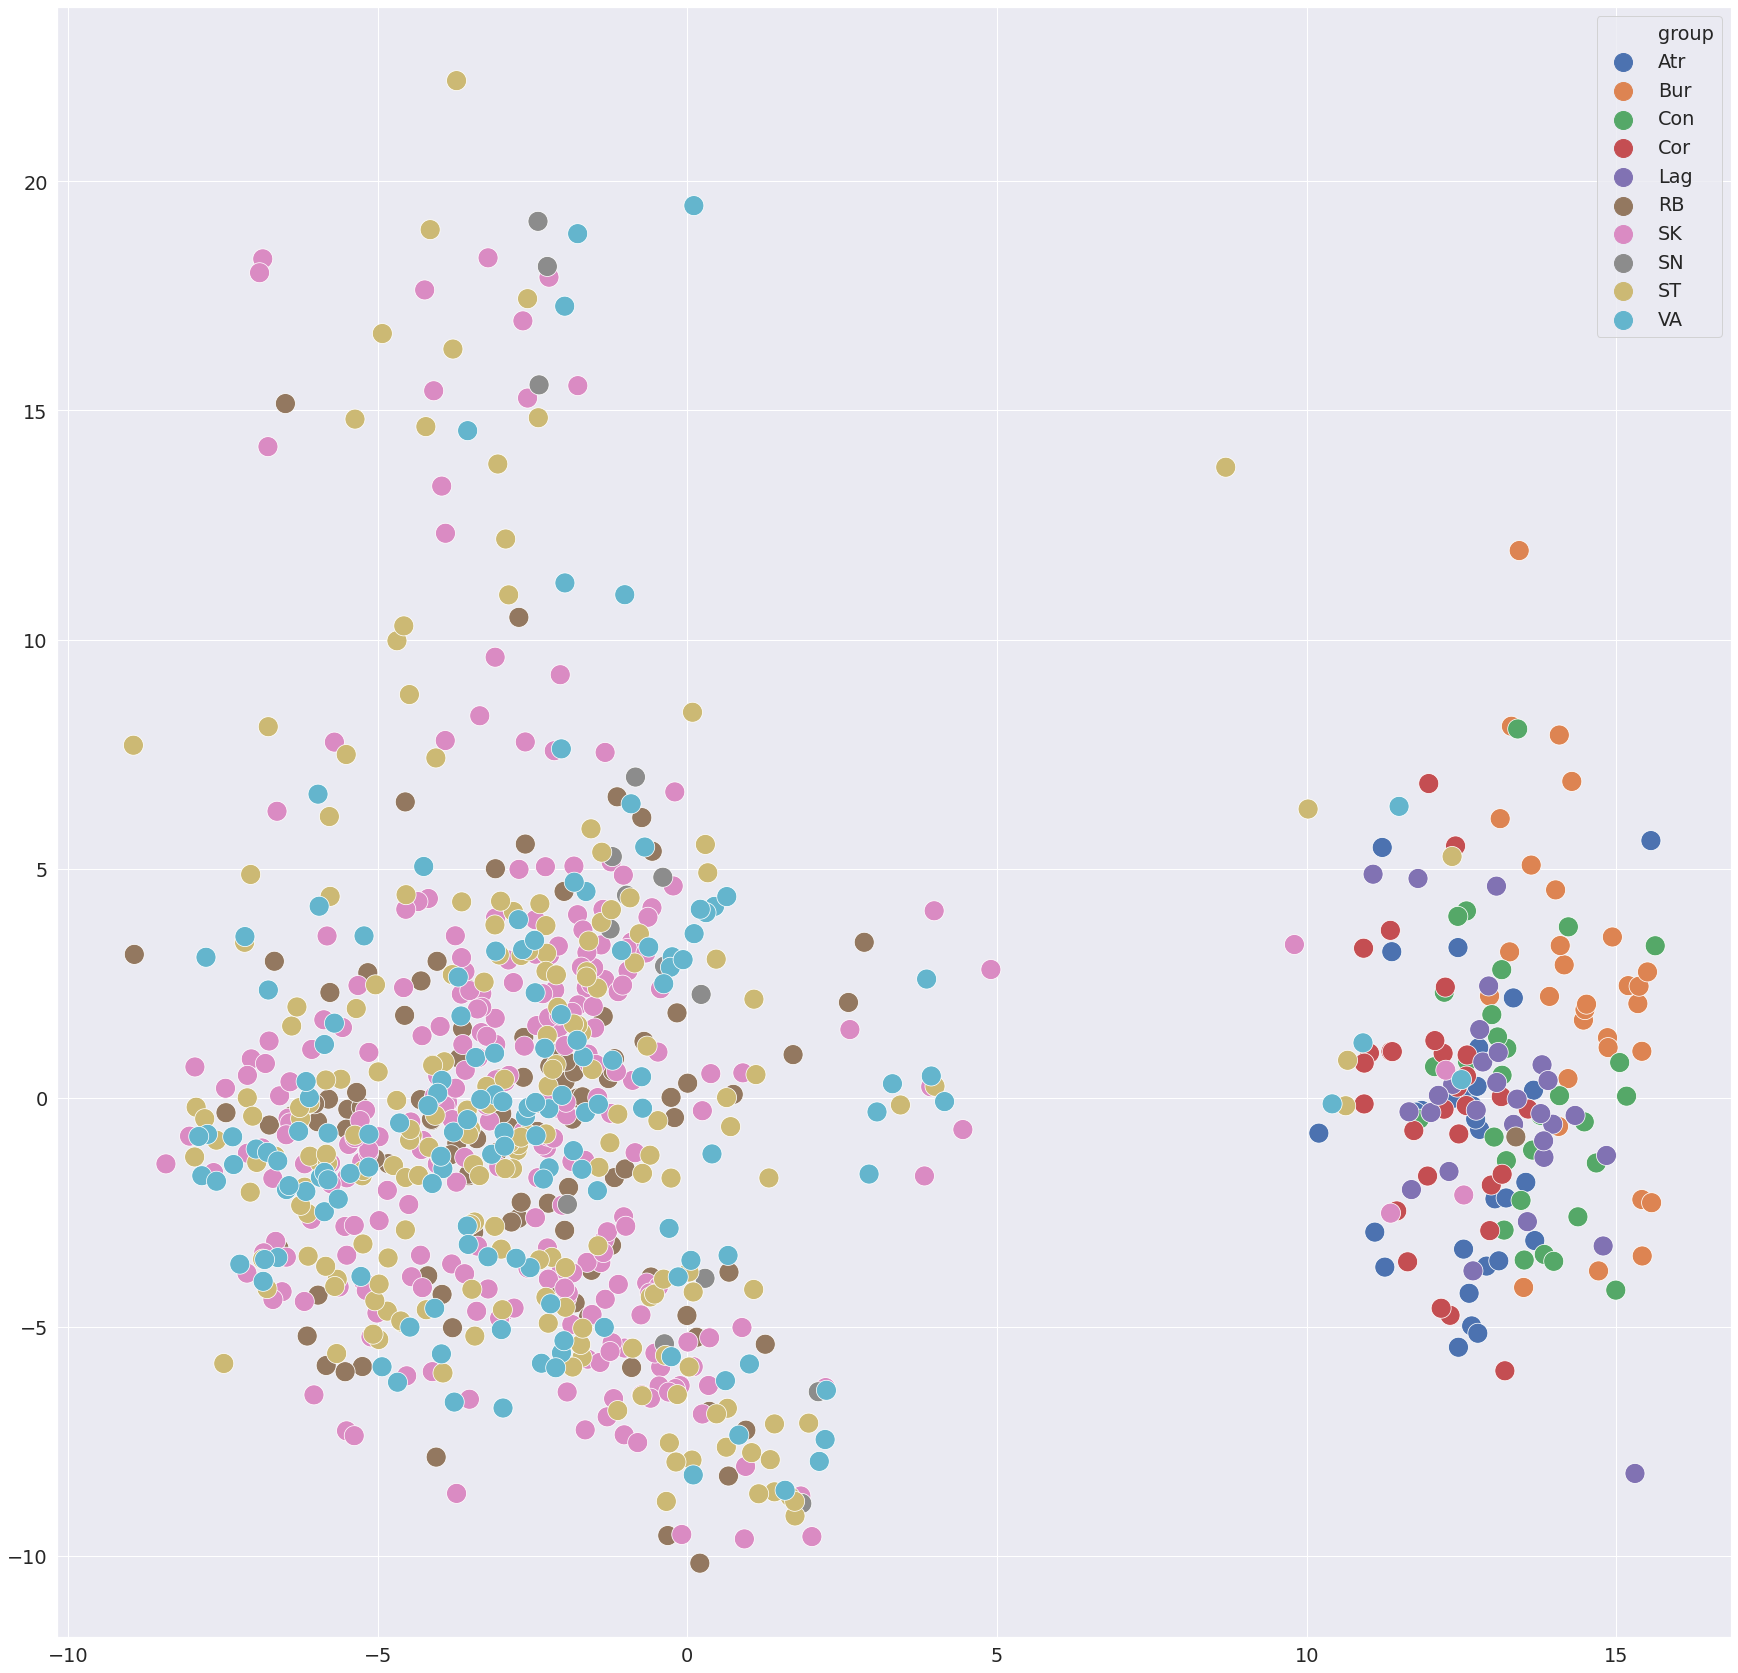

In [216]:
plt.rcParams['figure.figsize']=(30,30)
sns.scatterplot(X[:,0],X[:,1], hue=het['group'], s=400)
plt.legend(loc='upper right', markerscale=3., scatterpoints=1)

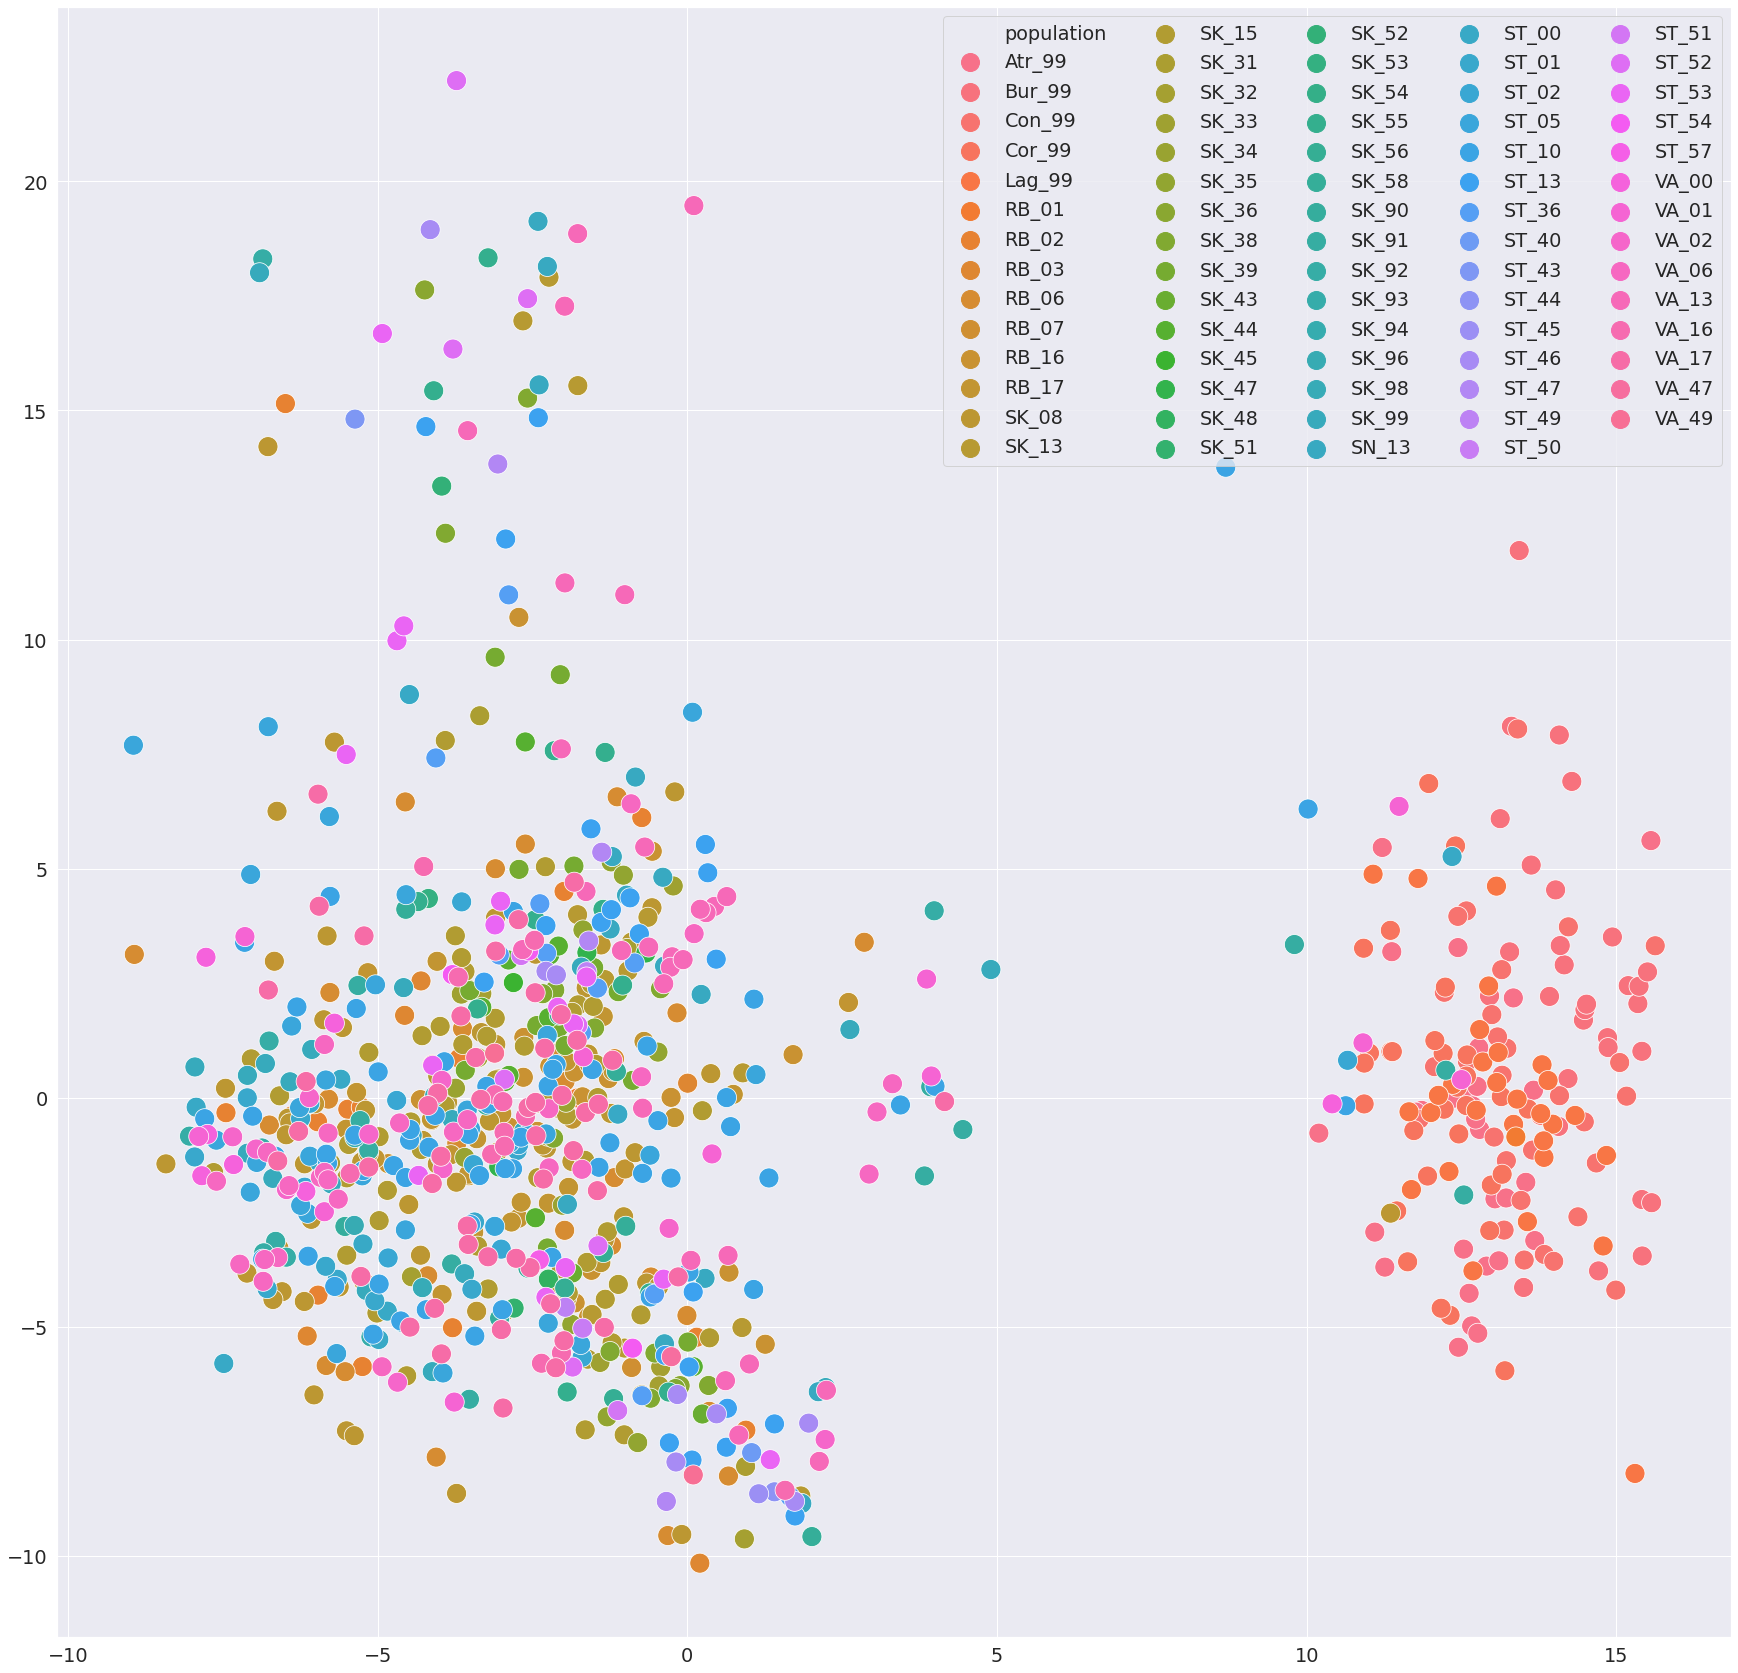

In [215]:
plt.rcParams['figure.figsize']=(30,30)
ax=sns.scatterplot(X[:,0],X[:,1], hue=het['population'], s=400)
plt.legend(loc='upper right', ncol=5, markerscale=3., scatterpoints=1)